In [19]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
from model2 import get_model
import torch

model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = get_model()


Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import nltk
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import Dataset, DataLoader

# Download the Penn TreeBank dataset
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [21]:
from nltk.corpus import treebank

# Load the dataset
sentences = treebank.tagged_sents()


In [26]:
len(sentences)

3914

In [18]:
text = "A test example"
model = model.to("cuda")
inputs = tokenizer(text, return_tensors="pt").to("cuda")
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)
predictions = predictions.cpu().numpy()

# Convert to labels
label_list = model.config.id2label
labeled_predictions = [label_list[id] for id in predictions[0]]

# Combine tokens and predictions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
result = list(zip(tokens, labeled_predictions))

print(result)

[('[CLS]', 'NN'), ('A', 'DT'), ('test', 'NN'), ('example', 'NN'), ('[SEP]', 'NN')]


In [8]:
for n,m in model.named_modules():
    print(n)
    # print(m)


bert
bert.embeddings
bert.embeddings.word_embeddings
bert.embeddings.position_embeddings
bert.embeddings.token_type_embeddings
bert.embeddings.LayerNorm
bert.embeddings.dropout
bert.encoder
bert.encoder.layer
bert.encoder.layer.0
bert.encoder.layer.0.attention
bert.encoder.layer.0.attention.self
bert.encoder.layer.0.attention.self.query
bert.encoder.layer.0.attention.self.key
bert.encoder.layer.0.attention.self.value
bert.encoder.layer.0.attention.self.dropout
bert.encoder.layer.0.attention.output
bert.encoder.layer.0.attention.output.dense
bert.encoder.layer.0.attention.output.LayerNorm
bert.encoder.layer.0.attention.output.dropout
bert.encoder.layer.0.intermediate
bert.encoder.layer.0.intermediate.dense
bert.encoder.layer.0.intermediate.intermediate_act_fn
bert.encoder.layer.0.output
bert.encoder.layer.0.output.dense
bert.encoder.layer.0.output.LayerNorm
bert.encoder.layer.0.output.dropout
bert.encoder.layer.1
bert.encoder.layer.1.attention
bert.encoder.layer.1.attention.self
bert.e

In [32]:
import nltk
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW
from sklearn.metrics import f1_score

# Download the Penn TreeBank dataset
nltk.download('treebank')

from nltk.corpus import treebank

# Load the dataset
sentences = treebank.tagged_sents()

# Split the dataset into train and test sets
train_size = int(0.8 * len(sentences))
train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]

class PennTreebankDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tag2id = {tag: i for i, tag in enumerate(set([tag for sent in self.sentences for _, tag in sent]))}
        self.id2tag = {i: tag for tag, i in self.tag2id.items()}

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence, tags = zip(*self.sentences[idx])
        sentence = " ".join(sentence)
        
        encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        # Align tags with tokenized words
        aligned_tags = []
        words = self.tokenizer.tokenize(sentence)
        for word, tag in zip(sentence.split(), tags):
            tokens = self.tokenizer.tokenize(word)
            aligned_tags.extend([tag] * len(tokens))
        
        # Pad or truncate tags to match input_ids length
        if len(aligned_tags) > self.max_length - 2:
            aligned_tags = aligned_tags[:self.max_length - 2]
        
        # Add tags for [CLS] and [SEP]
        aligned_tags = [aligned_tags[0]] + aligned_tags + [aligned_tags[-1]]
        
        # Pad with the last tag if necessary
        aligned_tags += [aligned_tags[-1]] * (self.max_length - len(aligned_tags))
        
        # Convert tags to IDs
        tag_ids = [self.tag2id[tag] for tag in aligned_tags]
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(tag_ids)
        }
# Set up the model and tokenizer
model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Create datasets and dataloaders
train_dataset = PennTreebankDataset(train_sentences, tokenizer)
test_dataset = PennTreebankDataset(test_sentences, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation and F1 score calculation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # Remove padding and special tokens
        for pred, label, mask in zip(predictions, labels, attention_mask):
            pred = pred[mask.bool()][1:-1]
            label = label[mask.bool()][1:-1]
            all_predictions.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=list(train_dataset.tag2id.keys())))

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

Weighted F1 Score: 0.1134

Classification Report:
              precision    recall  f1-score   support

          RP       0.69      0.85      0.76        34
         JJS       0.90      0.98      0.94        45
          RB       0.95      0.98      0.97       630
          TO       1.00      1.00      1.00       464
         JJR       0.92      0.95      0.94        84
          IN       0.99      0.98      0.99      1953
         PDT       0.00      0.00      0.00         6
         SYM       0.00      0.00      0.00        28
         WRB       0.00      0.00      0.00       602
          LS       0.00      0.00      0.00       104
         VBN       0.00      0.00      0.00       597
       -RRB-       0.00      0.00      0.00       388
          VB       0.00      0.00      0.00      1768
         VBZ       0.00      0.00      0.00      3741
          JJ       0.00      0.00      0.00       930
           ,       0.00      0.00      0.00       106
          NN       0.00      0.

/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [41]:
import nltk
from nltk.corpus import treebank
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from transformers import pipeline
from sklearn.metrics import classification_report

# Download the treebank dataset
nltk.download('treebank')

# Load the model and tokenizer
model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Get the tag set and label mapping
label_list = model.config.id2label

# Load the dataset
sentences = treebank.tagged_sents()

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
from torch.utils import data
class PosDataset(data.Dataset):
    def __init__(self, tagged_sents,tokenizer,tag2idx,idx2tag):
        sents, tags_li = [], [] # list of lists
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.idx2tag = idx2tag
        for sent in tagged_sents:
            words = [word_pos[0] for word_pos in sent]
            tags = [word_pos[1] for word_pos in sent]
            sents.append(["[CLS]"] + words + ["[SEP]"])
            tags_li.append(["<pad>"] + tags + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

        # We give credits only to the first piece.
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = self.tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = self.tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [self.tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen

In [48]:
tagged_sents = treebank.tagged_sents()
print(len(tagged_sents))
print(tagged_sents[0])
tags = list(set(word_pos[1] for sent in tagged_sents for word_pos in sent))
tags = ["<pad>"] + tags
tags_str = ','.join(tags)
print(len(tags_str))
print(tags_str)
tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}
dataset = PosDataset(sentences,tokenizer,tag2idx,idx2tag)

3914
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
170
<pad>,RP,JJS,RB,TO,JJR,IN,PDT,SYM,WRB,LS,VBN,-RRB-,VB,VBZ,JJ,,,NN,:,-LRB-,``,NNPS,#,PRP$,NNS,$,EX,WDT,VBD,PRP,VBG,.,UH,POS,'',RBR,MD,CD,CC,VBP,-NONE-,FW,WP$,NNP,WP,RBS,DT


In [69]:
from tqdm import tqdm
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for words, x, is_heads, tags, y, seqlen in tqdm(dataset):
        
        x = torch.tensor(x).unsqueeze(0)
        outputs = model(x).logits
        predictions = torch.argmax(outputs, dim=2).squeeze().tolist()
        
        

  0%|          | 0/3914 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [65]:
true_labels[0]

['<',
 'p',
 'a',
 '>',
 ' ',
 'N',
 'N',
 'P',
 ' ',
 'N',
 'N',
 'P',
 ' ',
 ',',
 ' ',
 'N',
 'N',
 ' ',
 'J',
 'J']

In [66]:
pred_labels[0]

['.',
 'NNP',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 ',',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 'DT',
 'JJ',
 'NN',
 'NNP',
 'CD',
 '.',
 '.']

In [1]:
from datasets import load_dataset, concatenate_datasets

from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
import random
import numpy as np
from utilities import evaluate_gpt2_classification as evaluate_gpt2_classification, mask_range_gpt,compute_masks, reset_gpt, compute_mask_probe
import torch  
from tqdm import tqdm

dataset_names = ["stanfordnlp/imdb", "fancyzhx/dbpedia_14", "dair-ai/emotion", "fancyzhx/ag_news",  "stanfordnlp/sst2"]
text_tags = ["text", "content", "text", "text", "sentence"]
nymber_of_classes = [2, 14, 6, 4, 2]


# dataset_names = ["fancyzhx/dbpedia_14"]
# text_tags = ["content"]
# nymber_of_classes = [14]

# dataset_names = ["fancyzhx/ag_news"]
# text_tags = ["text"]
# nymber_of_classes = [4]
dataset_fc = []
for dataset_name, text_tag, num_classes in zip(dataset_names, text_tags, nymber_of_classes):
    # remove everything from cuda
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    torch.cuda.ipc_collect()
    # text_tag = "text"

    # Load dataset and tokenizer


    tables = []
    layer = 11
    # for i in tqdm(range(1, 21)):
    per = 0.3
    print("Percentage: ", per)
    # num_classes = 6

    # tao = 2.5

    lab = "label"
    # tao = torch.inf

    dataset = load_dataset(dataset_name)

    print(dataset)
    # Set random seed
    seed_value = 42  # or any other integer

    random.seed(seed_value)
    np.random.seed(seed_value)

    if torch.cuda.is_available():  # PyTorch-specific
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    import torch

    torch.autograd.set_detect_anomaly(True)
    # Load tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


    special_tokens_dict = {}
    new_tokens = []
    label2text = dataset['train'].features[lab].names

    for label in label2text:
        # Create special token format (with and without space)
        special_token = f'{label}'
        
        # Check if the label is already a single token in the tokenizer
        label_tokens = tokenizer.encode(label, add_special_tokens=False)
        is_single_token = len(label_tokens) == 1
        
        if is_single_token:
            print(f"'{label}' is already a single token (ID: {label_tokens[0]})")
        
        # Add both versions to new tokens list
        new_tokens.extend([special_token])

    # Add the tokens to the tokenizer
    num_added_tokens = tokenizer.add_tokens(new_tokens)
    print(f"\nAdded {num_added_tokens} new tokens to the tokenizer")

    special_tokens = {
        'pad_token': '<|pad|>',
        'sep_token': '<|sep|>',
        'eos_token': '<|eos|>'
    }
    tokenizer.add_special_tokens(special_tokens)

    def format_data(examples):
        formatted_texts = []
        for text, label in zip(examples[text_tag], examples[lab]):
            # Convert label to string
            
            tok_text = tokenizer.encode(text, max_length=400, truncation=True)
            text = tokenizer.decode(tok_text)
            label_str = dataset['train'].features[lab].int2str(label)
            formatted_text = f"Classify emotion: {text}{tokenizer.sep_token}"#{label_str}{tokenizer.eos_token}"
            formatted_texts.append(formatted_text)
        return {'formatted_text': formatted_texts}

    def tokenize_and_prepare(examples):

        # Tokenize with batch processing
        tokenized = tokenizer(
            examples['formatted_text'],
            padding='max_length',
            max_length=408,
            truncation=True,
            return_tensors="pt"
        )
        
        # Clone input_ids to create labels
        labels = tokenized['input_ids'].clone()
        
        # Find the position of sep_token
        sep_token_id = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
        sep_positions = (labels == sep_token_id).nonzero(as_tuple=True)
        
        # Mask all tokens with -100 except for the token right after sep_token
        labels[:] = -100  # Mask all initially
        for batch_idx, sep_pos in zip(*sep_positions):
            if sep_pos + 1 < labels.size(1):
                labels[batch_idx, sep_pos + 1] = tokenized['input_ids'][batch_idx, sep_pos + 1]
        
        # Set padding tokens to -100
        labels[labels == tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': tokenized['input_ids'],
            'attention_mask': tokenized['attention_mask'],
            'labels': labels
        }
        
    # drop -1 label split from the dataset
    dataset = dataset.filter(lambda x: x[lab] != -1)
    # Process the dataset
    formatted_dataset = dataset.map(format_data, batched=True)
    tokenized_dataset = formatted_dataset.map(
        tokenize_and_prepare, 
        batched=True,
    )

    from transformers import GPT2LMHeadModel as gt
    from models.gpt2 import GPT2LMHeadModel
    # Load pre-trained GPT-2 model
    model1 = gt.from_pretrained('gpt2')

    model1.resize_token_embeddings(len(tokenizer))

    model1.config.m_layer = layer
    import os

    base_path = os.path.join("model_weights", dataset_name)
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    weights_path = os.path.join(base_path, "weights.pth")

    model = GPT2LMHeadModel(model1.config)


    model.load_state_dict(torch.load(weights_path))




    from prettytable import PrettyTable
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="torch.tensor")

    batch_size = 2048/2
    # mask_layer = 5
    compliment = True
    results_table = PrettyTable()
    if(compliment):
        results_table.field_names = results_table.field_names = ["Class", "Base Accuracy", "Base Confidence", "Base Complement Acc", "Base Compliment Conf", "STD Accuracy", "STD Confidence", "STD compliment ACC", "STD compliment Conf", "MAX Accuracy", "MAX Confidence", "Max compliment acc", "Max compliment conf", "Total Masked", "Intersection"]#, "Same as Max"]#"MAX Accuracy", "MAX Confidence", "Max compliment acc", "Max compliment conf"

    class_labels = []
    base_accuracies = []
    base_confidences = []
    base_comp_acc = []
    base_comp_conf = []
    std_masked_counts = []
    std_accuracies = []
    std_confidences = []
    std_comp_acc = []
    std_comp_conf = []
    max_masked_counts = []
    max_accuracies = []
    max_confidences = []
    max_comp_acc = []
    max_comp_conf = []
    diff_from_max = []
    total_masked = []

    #merge test and train set and then shuffle and make splits

    # First merge and shuffle
    tokenized_dataset = concatenate_datasets([tokenized_dataset['train'], tokenized_dataset['test']]).shuffle(seed=42)

    # Get the total length
    dataset_length = len(tokenized_dataset)

    # Calculate split index
    split_index = int(dataset_length * 0.2)  # 80% for training

    # Create the splits using dataset slicing
    tokenized_dataset1 = tokenized_dataset.select(range(split_index))  # training set
    recording_dataset = tokenized_dataset.select(range(split_index, dataset_length))

    all_fc_vals = []
    print("Recording activations...")
    for j in range(0,num_classes):
        dataset_recording = recording_dataset.filter(lambda x: x[lab] in [j]).shuffle().select(range(2000))
        fc_vals = evaluate_gpt2_classification(lab, model, dataset_recording, tokenizer)
        fc_vals = fc_vals[2]
        all_fc_vals.append(fc_vals)
    dataset_fc.append(all_fc_vals)


Using the latest cached version of the dataset since stanfordnlp/imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /u/amo-d1/grad/mha361/.cache/huggingface/datasets/stanfordnlp___imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Fri Jan 24 16:26:54 2025).


Percentage:  0.3
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


'neg' is already a single token (ID: 12480)
'pos' is already a single token (ID: 1930)

Added 0 new tokens to the tokenizer


/tmp/ipykernel_1297786/4136954449.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


Recording activations...


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:668: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(item['input_ids']).to(device)
/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:669: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(item['attention_mask']).to(device)


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Using the latest cached version of the dataset since fancyzhx/dbpedia_14 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'dbpedia_14' at /u/amo-d1/grad/mha361/.cache/huggingface/datasets/fancyzhx___dbpedia_14/dbpedia_14/0.0.0/9abd46cf7fc8b4c64290f26993c540b92aa145ac (last modified on Wed Jan 22 22:38:49 2025).


Percentage:  0.3
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 70000
    })
})


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


'Company' is already a single token (ID: 39154)
'Artist' is already a single token (ID: 43020)
'Building' is already a single token (ID: 25954)
'Animal' is already a single token (ID: 40002)
'Film' is already a single token (ID: 39750)

Added 9 new tokens to the tokenizer


/tmp/ipykernel_1297786/4136954449.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


Recording activations...


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:668: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(item['input_ids']).to(device)
/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:669: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(item['attention_mask']).to(device)


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Using the latest cached version of the dataset since dair-ai/emotion couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'split' at /u/amo-d1/grad/mha361/.cache/huggingface/datasets/dair-ai___emotion/split/0.0.0/cab853a1dbdf4c42c2b3ef2173804746df8825fe (last modified on Sun Jan  5 16:22:31 2025).


Percentage:  0.3
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


'joy' is already a single token (ID: 2633)
'love' is already a single token (ID: 23205)
'anger' is already a single token (ID: 2564)

Added 3 new tokens to the tokenizer


/tmp/ipykernel_1297786/4136954449.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


Recording activations...


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:668: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(item['input_ids']).to(device)
/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:669: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(item['attention_mask']).to(device)


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

IndexError: Index 1999 out of range for dataset of size 1177.

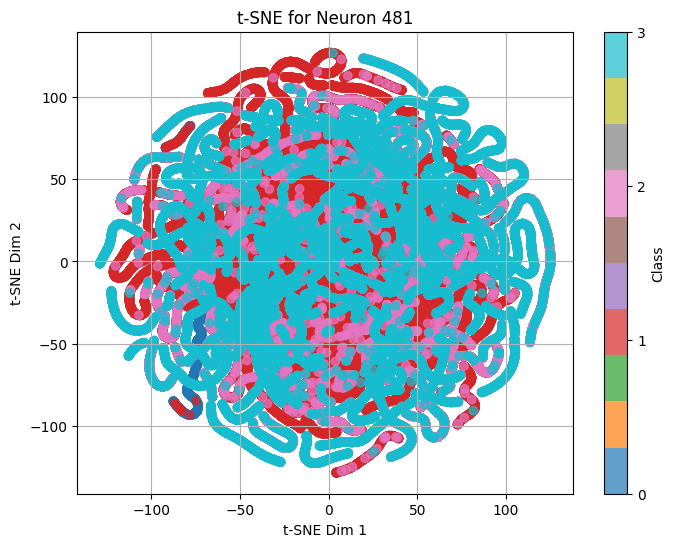

In [25]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

from openTSNE import TSNE



# Example inputs
# activations: List of shape (num_classes, num_samples, hidden_size)
# Replace this with your actual activation data.
num_classes = 4
activations = dataset_fc[0]
hidden_size = activations[0][0].shape[-1]

# Select a hidden dimension (neuron)
selected_neuron = 42  # Replace with the neuron index you want to analyze
assert 0 <= selected_neuron < hidden_size, "Invalid neuron index."

# Extract activations for the selected neuron
# Shape after extraction: (num_classes * num_samples, )
selected_neuron = 481  # Replace with the neuron index you want to analyze
assert 0 <= selected_neuron < hidden_size, "Invalid neuron index."

# Extract activations for the selected neuron
# Flattening to 1D per class and collecting labels
extracted_activations = []
labels = []

for class_idx, class_activations in enumerate(activations):
    neuron_activations = np.array(class_activations)[:, selected_neuron]
    extracted_activations.append(neuron_activations)
    labels.extend([class_idx] * len(neuron_activations))

# Concatenate all activations into a single array
extracted_activations = np.concatenate(extracted_activations).reshape(-1, 1)

# Perform t-SNE
# Perform t-SNE with random initialization
tsne = TSNE(
    n_components=2,
    random_state=42,
    negative_gradient_method="fft",
    initialization="random",  # Skip PCA, use random initialization
)
tsne_results = tsne.fit(extracted_activations)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(num_classes), label="Class")
plt.title(f"t-SNE for Neuron {selected_neuron}")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()

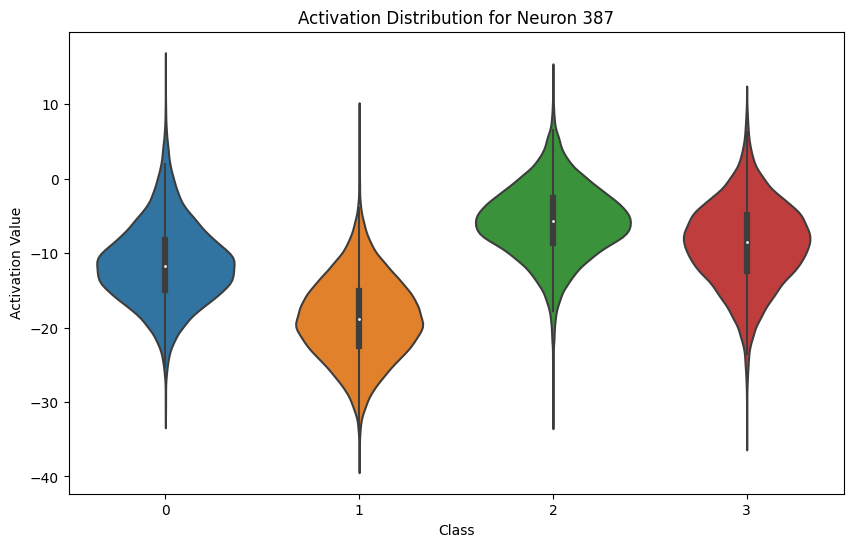

In [34]:
import seaborn as sns
selected_neuron = 387
plt.figure(figsize=(10, 6))
sns.violinplot(data=[np.array(activations[class_idx])[:, selected_neuron] for class_idx in range(num_classes)])
plt.title(f"Activation Distribution for Neuron {selected_neuron}")
plt.xlabel("Class")
plt.ylabel("Activation Value")
plt.show()

In [23]:
!pip install -c rapidsai -c nvidia -c conda-forge cuml=23.10 python=3.9 cudatoolkit=11.8

8568.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rapidsai'


In [16]:
#clear gpu memory
torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.cuda.ipc_collect()


In [10]:
type(dataset_fc[0][00])

numpy.ndarray

In [3]:
len(dataset_fc)

5

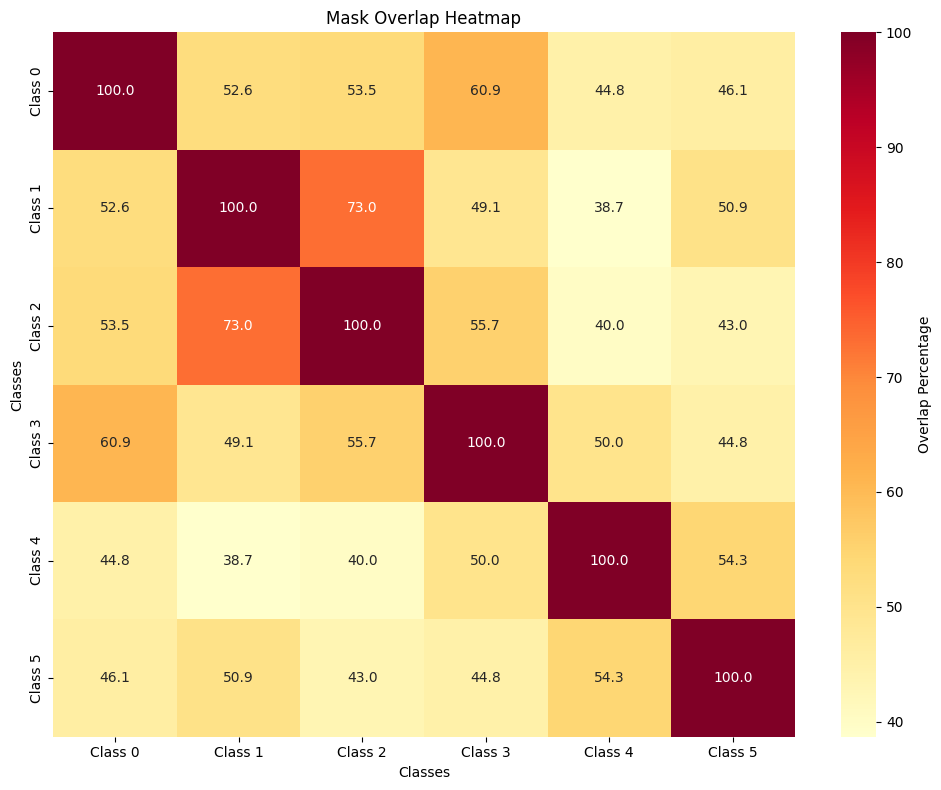

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def compute_mask_overlap(all_masks):
    """
    Compute the overlap of masked positions (zeros) between different classes,
    specifically checking for masks at the same indices.
    
    Parameters:
    all_masks: List of PyTorch tensors, where each tensor contains the mask for a class
              (0 represents masked positions)
    
    Returns:
    overlap_matrix: 2D numpy array containing overlap percentages
    intersection_indices: Dictionary storing the indices that overlap between each pair of classes
    """
    num_classes = len(all_masks)
    overlap_matrix = torch.zeros((num_classes, num_classes))
    intersection_indices = {}  # Store overlapping indices for each pair
    
    for i in range(num_classes):
        mask_i = all_masks[i]
        # Get indices where mask is 0 (masked positions)
        zeros_i = torch.where(mask_i == 0)[0]
        total_zeros_i = len(zeros_i)
        
        for j in range(num_classes):
            mask_j = all_masks[j]
            # Get indices where mask is 0
            zeros_j = torch.where(mask_j == 0)[0]
            
            # Find common indices using set intersection
            common_indices = set(zeros_i.tolist()) & set(zeros_j.tolist())
            
            # Store overlapping indices
            intersection_indices[f"{i}-{j}"] = common_indices
            
            # Calculate percentage of overlap
            overlap_percentage = (len(common_indices) / total_zeros_i) * 100
            overlap_matrix[i, j] = overlap_percentage
    
    return overlap_matrix.numpy(), intersection_indices

def plot_overlap_heatmap(overlap_matrix, title="Mask Overlap Heatmap"):
    """
    Create a heatmap visualization of the overlap matrix.
    
    Parameters:
    overlap_matrix: 2D numpy array containing overlap percentages
    title: String for the plot title
    """
    plt.figure(figsize=(10, 8))
    
    # Store the heatmap object
    heatmap = sns.heatmap(overlap_matrix, 
                         annot=True, 
                         fmt='.1f',
                         cmap='YlOrRd',
                         xticklabels=[f'Class {i}' for i in range(len(overlap_matrix))],
                         yticklabels=[f'Class {i}' for i in range(len(overlap_matrix))])
    
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Classes')
    
    # Get the current figure and add colorbar
    fig = heatmap.get_figure()
    cbar = fig.axes[-1]  # The colorbar is the last axes object
    cbar.set_ylabel('Overlap Percentage')
    
    plt.tight_layout()
    return plt

def analyze_mask_overlap(all_fc_vals, per, num_classes):
    """
    Analyze and visualize mask overlap across classes.
    
    Parameters:
    all_fc_vals: List of feature values for each class
    per: Percentage parameter for compute_masks function
    num_classes: Number of classes to analyze
    """
    # Store all mask_max values
    all_masks = []
    
    for j in range(num_classes):
        # Compute masks using your existing function
        mask_max, mask_std, mask_intersection, mask_max_low_std, \
        mask_max_high_std, mask_std_high_max, mask_max_random_off, \
        random_mask = compute_masks(all_fc_vals[j], per)
        
        # Store the mask_max for overlap analysis
        all_masks.append(mask_max)
    
    # Compute overlap matrix and get intersection indices
    overlap_matrix, intersection_indices = compute_mask_overlap(all_masks)
    
    # Create and show heatmap
    plt = plot_overlap_heatmap(overlap_matrix)
    plt.show()
    
    return overlap_matrix, intersection_indices

# Example of how to use the functions:
overlap_matrix = analyze_mask_overlap(all_fc_vals, 0.3, num_classes)

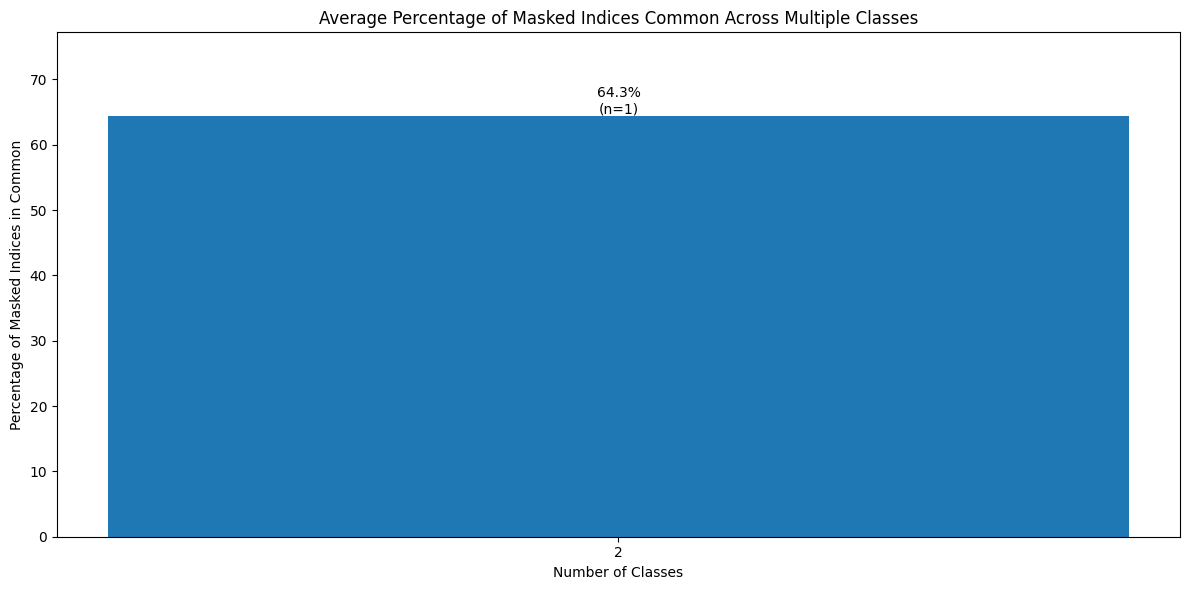


Detailed overlap statistics:
2 classes: 64.3% average overlap across 1 combinations


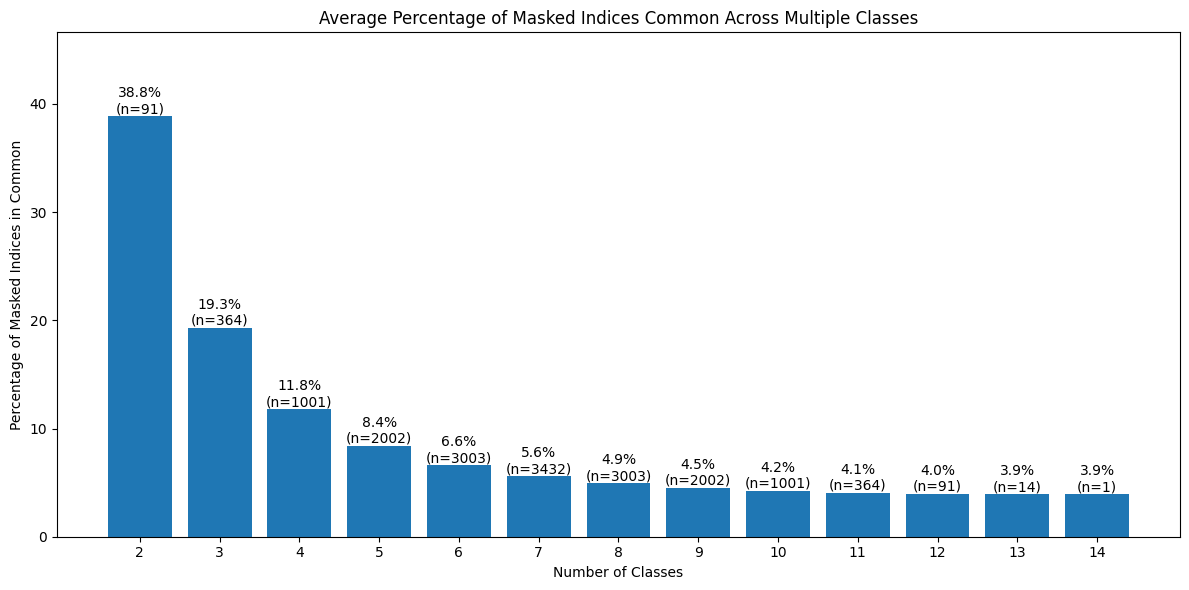


Detailed overlap statistics:
2 classes: 38.8% average overlap across 91 combinations
3 classes: 19.3% average overlap across 364 combinations
4 classes: 11.8% average overlap across 1001 combinations
5 classes: 8.4% average overlap across 2002 combinations
6 classes: 6.6% average overlap across 3003 combinations
7 classes: 5.6% average overlap across 3432 combinations
8 classes: 4.9% average overlap across 3003 combinations
9 classes: 4.5% average overlap across 2002 combinations
10 classes: 4.2% average overlap across 1001 combinations
11 classes: 4.1% average overlap across 364 combinations
12 classes: 4.0% average overlap across 91 combinations
13 classes: 3.9% average overlap across 14 combinations
14 classes: 3.9% average overlap across 1 combinations


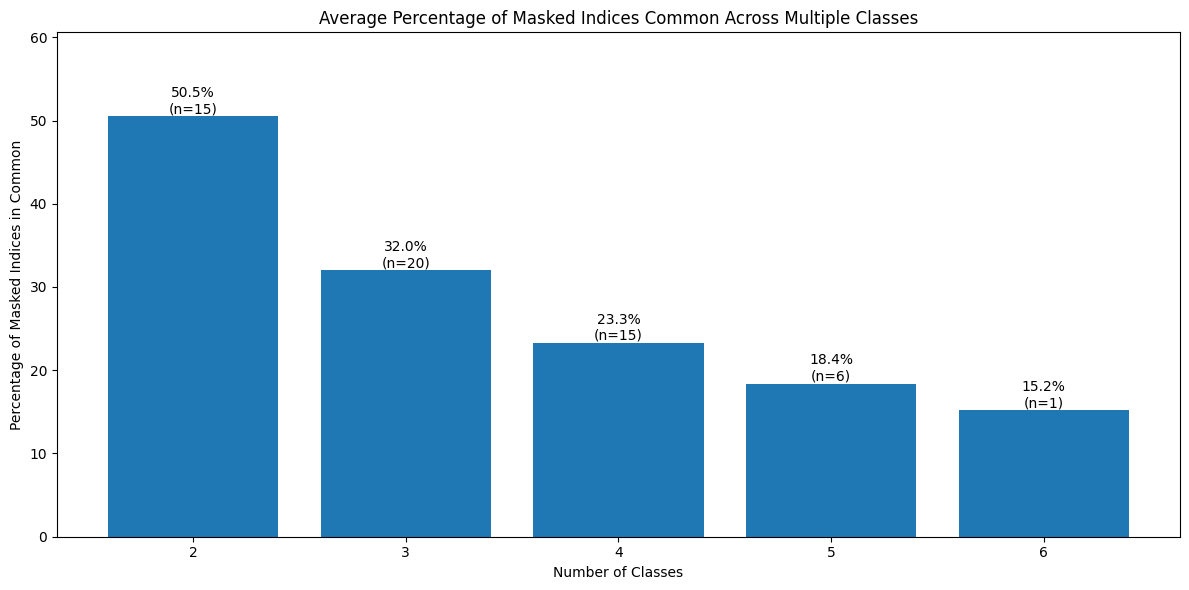


Detailed overlap statistics:
2 classes: 50.5% average overlap across 15 combinations
3 classes: 32.0% average overlap across 20 combinations
4 classes: 23.3% average overlap across 15 combinations
5 classes: 18.4% average overlap across 6 combinations
6 classes: 15.2% average overlap across 1 combinations


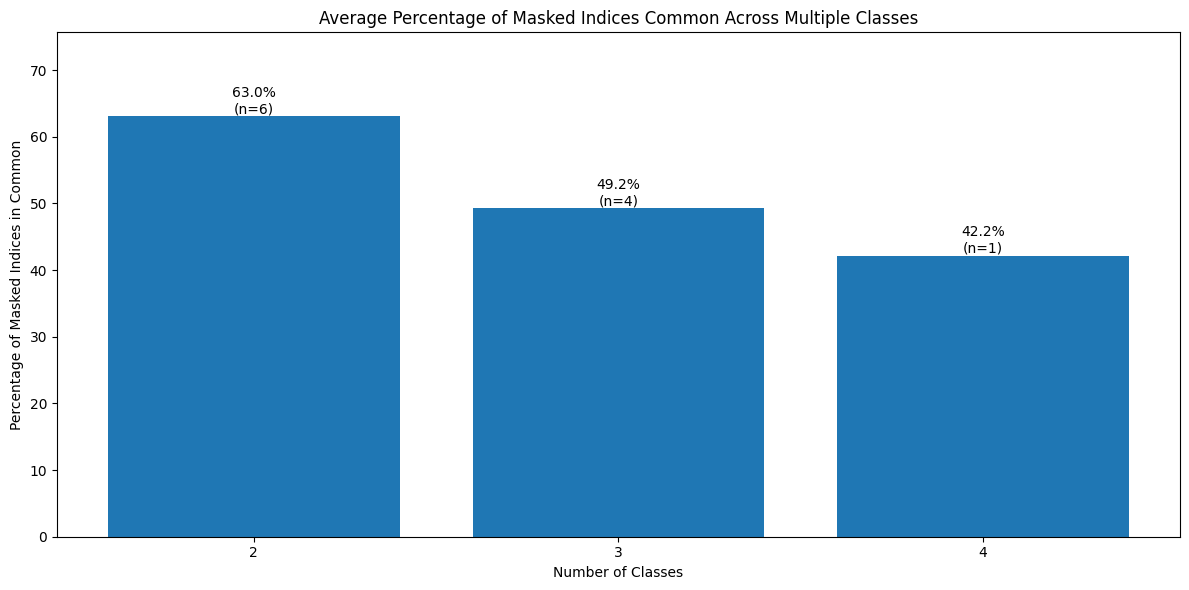


Detailed overlap statistics:
2 classes: 63.0% average overlap across 6 combinations
3 classes: 49.2% average overlap across 4 combinations
4 classes: 42.2% average overlap across 1 combinations


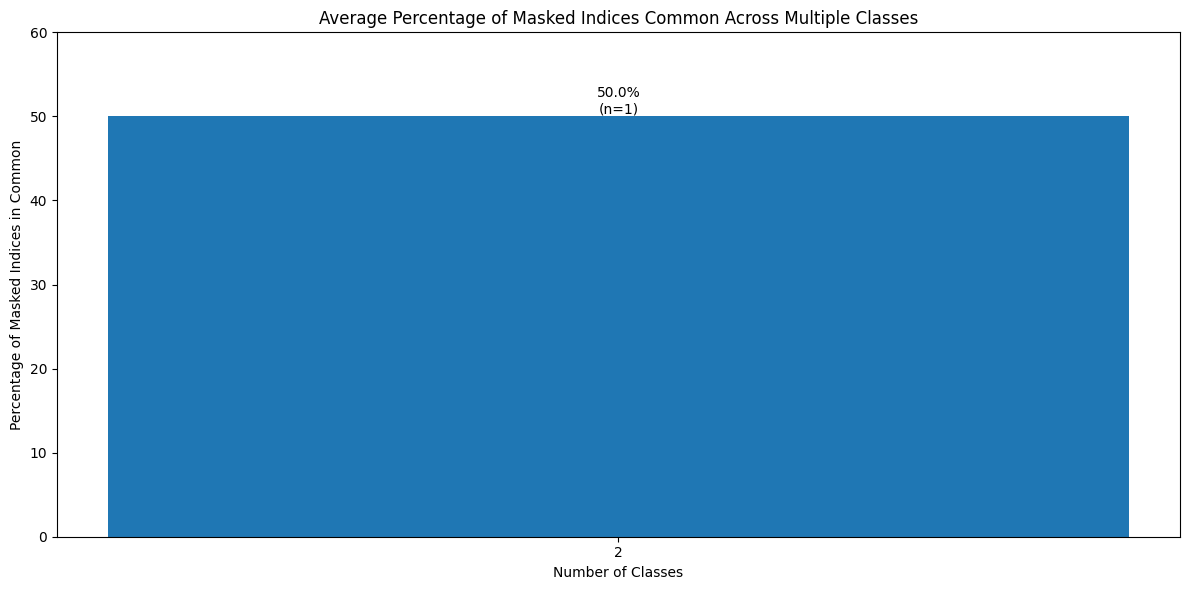


Detailed overlap statistics:
2 classes: 50.0% average overlap across 1 combinations


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import torch

def analyze_multi_class_overlap(all_masks):
    """
    Analyze the average percentage of masked indices that overlap across different numbers of classes.
    
    Parameters:
    all_masks: List of PyTorch tensors containing masks for each class
    
    Returns:
    overlap_percentages: Dictionary with number of classes as key and average overlap percentage as value
    overlap_details: Dictionary with detailed information about which indices overlap
    combination_counts: Dictionary with number of combinations found for each k classes
    """
    num_classes = len(all_masks)
    
    # Get masked indices for each class
    class_indices = []
    total_masked = []
    for mask in all_masks:
        indices = set(torch.where(mask == 0)[0].tolist())
        class_indices.append(indices)
        total_masked.append(len(indices))
    
    overlap_percentages = {}
    overlap_details = {}
    combination_counts = {}
    
    # Check overlaps for different numbers of classes (2 to num_classes)
    for k in range(2, num_classes + 1):
        class_combinations = list(combinations(range(num_classes), k))
        total_percentage = 0
        valid_combinations = 0
        
        for combo in class_combinations:
            # Get intersection of indices for this combination
            indices_in_combo = set.intersection(*[class_indices[i] for i in combo])
            
            if indices_in_combo:
                combo_key = '-'.join(map(str, combo))
                overlap_details[combo_key] = indices_in_combo
                
                # Calculate percentage relative to average number of masked neurons in this combination
                avg_masked_in_combo = np.mean([total_masked[i] for i in combo])
                overlap_percentage = (len(indices_in_combo) / avg_masked_in_combo) * 100
                
                total_percentage += overlap_percentage
                valid_combinations += 1
        
        # Store the average percentage and number of valid combinations
        if valid_combinations > 0:
            overlap_percentages[k] = total_percentage / valid_combinations
        else:
            overlap_percentages[k] = 0
        combination_counts[k] = valid_combinations
    
    return overlap_percentages, overlap_details, combination_counts

def plot_multi_class_overlap(overlap_percentages, combination_counts):
    """
    Create a bar chart showing the average percentage of masked indices that overlap across multiple classes.
    
    Parameters:
    overlap_percentages: Dictionary with number of classes as key and average overlap percentage as value
    combination_counts: Dictionary with number of valid combinations for each k classes
    """
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    classes = list(overlap_percentages.keys())
    percentages = list(overlap_percentages.values())
    
    # Create bar chart
    bars = plt.bar(classes, percentages)
    
    # Customize the plot
    plt.title('Average Percentage of Masked Indices Common Across Multiple Classes')
    plt.xlabel('Number of Classes')
    plt.ylabel('Percentage of Masked Indices in Common')
    
    # Add value labels on top of each bar with combination counts
    for bar, k in zip(bars, classes):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%\n(n={combination_counts[k]})',
                ha='center', va='bottom')
    
    # Set y-axis to percentage scale
    plt.ylim(0, min(100, max(percentages) * 1.2))  # Cap at 100% with some padding
    
    # Set x-axis to show only integer values
    plt.xticks(classes)
    
    plt.tight_layout()
    return plt

def analyze_and_plot_mask_overlap(all_fc_vals, per):
    """
    Main function to analyze and visualize multi-class mask overlap.
    """
    
    num_classes = len(all_fc_vals)
    # Get all masks
    all_masks = []
    for j in range(num_classes):
        mask_max, *_ = compute_masks(all_fc_vals[j], per)
        all_masks.append(mask_max)
    
    # Analyze overlap
    overlap_percentages, overlap_details, combination_counts = analyze_multi_class_overlap(all_masks)
    
    # Create visualization
    plt = plot_multi_class_overlap(overlap_percentages, combination_counts)
    plt.show()
    
    # Print additional statistics
    print("\nDetailed overlap statistics:")
    for k in overlap_percentages.keys():
        print(f"{k} classes: {overlap_percentages[k]:.1f}% average overlap across {combination_counts[k]} combinations")
    
    return overlap_percentages, overlap_details, combination_counts

# Example usage:
for all_fc_vals in dataset_fc:
    overlap_percentages, overlap_details, combination_counts = analyze_and_plot_mask_overlap(all_fc_vals, 0.3)

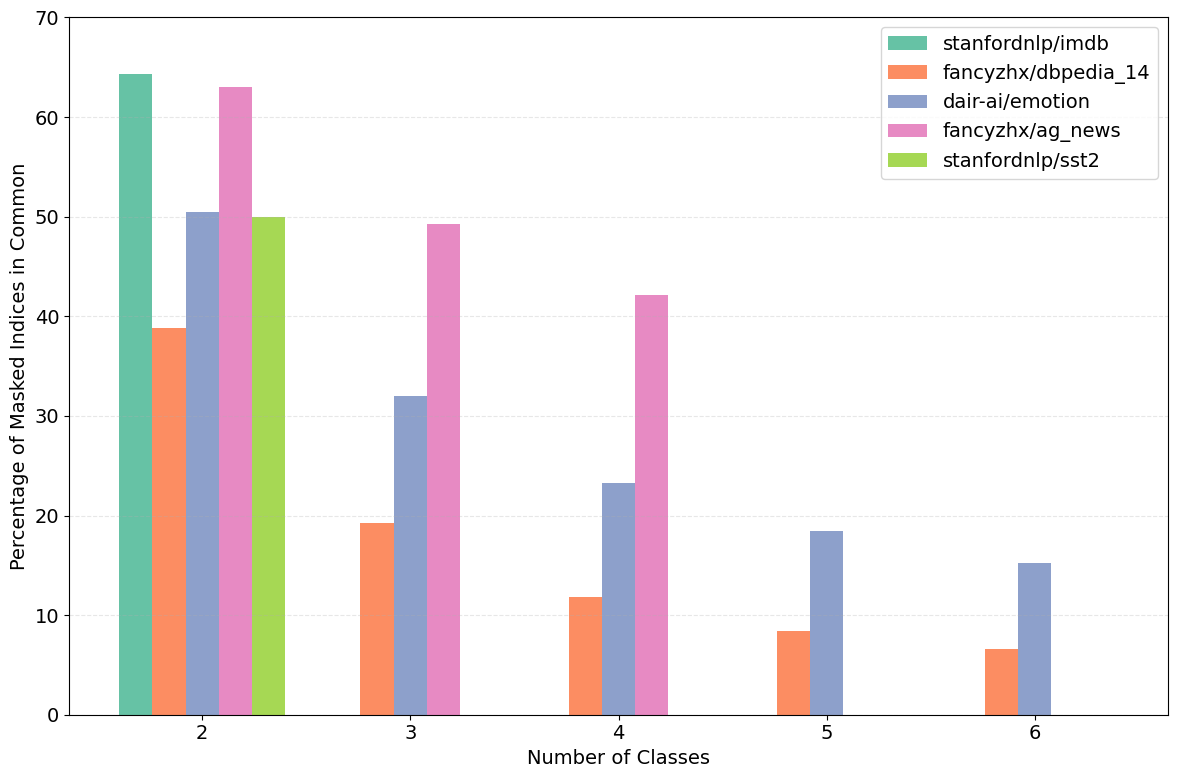


Detailed overlap statistics by dataset:

stanfordnlp/imdb:
2 classes: 64.3% average overlap across 1 combinations

fancyzhx/dbpedia_14:
2 classes: 38.8% average overlap across 91 combinations
3 classes: 19.3% average overlap across 364 combinations
4 classes: 11.8% average overlap across 1001 combinations
5 classes: 8.4% average overlap across 2002 combinations
6 classes: 6.6% average overlap across 3003 combinations
7 classes: 5.6% average overlap across 3432 combinations
8 classes: 4.9% average overlap across 3003 combinations
9 classes: 4.5% average overlap across 2002 combinations
10 classes: 4.2% average overlap across 1001 combinations
11 classes: 4.1% average overlap across 364 combinations
12 classes: 4.0% average overlap across 91 combinations
13 classes: 3.9% average overlap across 14 combinations
14 classes: 3.9% average overlap across 1 combinations

dair-ai/emotion:
2 classes: 50.5% average overlap across 15 combinations
3 classes: 32.0% average overlap across 20 combinat

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import torch

def analyze_multi_class_overlap(all_masks):
    """
    Analyze the average percentage of masked indices that overlap across different numbers of classes.
    
    Parameters:
    all_masks: List of PyTorch tensors containing masks for each class
    
    Returns:
    overlap_percentages: Dictionary with number of classes as key and average overlap percentage as value
    overlap_details: Dictionary with detailed information about which indices overlap
    combination_counts: Dictionary with number of combinations found for each k classes
    """
    num_classes = len(all_masks)
    
    # Get masked indices for each class
    class_indices = []
    total_masked = []
    for mask in all_masks:
        indices = set(torch.where(mask == 0)[0].tolist())
        class_indices.append(indices)
        total_masked.append(len(indices))
    
    overlap_percentages = {}
    overlap_details = {}
    combination_counts = {}
    
    # Check overlaps for different numbers of classes (2 to num_classes)
    for k in range(2, num_classes + 1):
        class_combinations = list(combinations(range(num_classes), k))
        total_percentage = 0
        valid_combinations = 0
        
        for combo in class_combinations:
            # Get intersection of indices for this combination
            indices_in_combo = set.intersection(*[class_indices[i] for i in combo])
            
            if indices_in_combo:
                combo_key = '-'.join(map(str, combo))
                overlap_details[combo_key] = indices_in_combo
                
                # Calculate percentage relative to average number of masked neurons in this combination
                avg_masked_in_combo = np.mean([total_masked[i] for i in combo])
                overlap_percentage = (len(indices_in_combo) / avg_masked_in_combo) * 100
                
                total_percentage += overlap_percentage
                valid_combinations += 1
        
        # Store the average percentage and number of valid combinations
        if valid_combinations > 0:
            overlap_percentages[k] = total_percentage / valid_combinations
        else:
            overlap_percentages[k] = 0
        combination_counts[k] = valid_combinations
    
    return overlap_percentages, overlap_details, combination_counts

def plot_multi_dataset_overlap(all_dataset_results, dataset_names):
    """
    Create a grouped bar chart showing the average percentage of masked indices that overlap across multiple classes
    for different datasets.
    
    Parameters:
    all_dataset_results: List of tuples (overlap_percentages, combination_counts) for each dataset
    dataset_names: List of dataset names
    """
    plt.figure(figsize=(12, 8))  # Increased width from 15 to 18
    # Set global font size
    plt.rcParams.update({'font.size': 14})
    # Define a color palette
    colors = sns.color_palette("Set2", n_colors=len(dataset_names))
    
    # Get all unique class numbers across datasets
    all_classes = sorted(set(k for result in all_dataset_results 
                           for k in result[0].keys()))
    
    all_classes = all_classes[:5]
    
    # Set the positions for the bars
    n_datasets = len(dataset_names)
    bar_width = 0.8 / n_datasets
    
    # Create bars for each dataset
    for i, (overlap_percentages, combination_counts) in enumerate(all_dataset_results):
        x_positions = [j + (i - n_datasets/2 + 0.5) * bar_width 
                      for j in range(len(all_classes))]
        
        # Get percentages for this dataset
        percentages = [overlap_percentages.get(k, 0) for k in all_classes]
        
        # Create bars
        bars = plt.bar(x_positions, percentages, 
                      bar_width, 
                      label=dataset_names[i],
                      alpha=1,
                      color=colors[i % len(colors)])
        
        # Add value labels on top of each bar
        for x, y, k in zip(x_positions, percentages, all_classes):
            count = combination_counts.get(k, 0)
            # if count > 0:
            #     plt.text(x, y, f'{y:.1f}%\n(n={count})',
            #             ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    # plt.title('Average Percentage of Masked Indices Common Across Multiple Classes\nComparison Across Datasets')
    plt.xlabel('Number of Classes', fontsize=14)
    plt.ylabel('Percentage of Masked Indices in Common', fontsize=14)
    
    # Set y-axis to percentage scale
    plt.ylim(0, 70)
    # plt.xlim(-0.5, len(all_classes) - 0.5)
    # Set x-axis ticks and labels
    plt.xticks(range(len(all_classes)), all_classes)
    
    # Add legend inside the plot
    plt.legend(loc='upper right')  # Changed from bbox_to_anchor to loc='upper right'
    
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    return plt

def analyze_and_plot_all_datasets(all_datasets_fc_vals, per, dataset_names):
    """
    Main function to analyze and visualize multi-class mask overlap across multiple datasets.
    """
    all_dataset_results = []
    
    # Analyze each dataset
    for dataset_fc_vals in all_datasets_fc_vals:
        num_classes = len(dataset_fc_vals)
        # Get all masks
        all_masks = []
        for j in range(num_classes):
            mask_max, *_ = compute_masks(dataset_fc_vals[j], per)
            all_masks.append(mask_max)
        
        # Analyze overlap
        overlap_percentages, overlap_details, combination_counts = analyze_multi_class_overlap(all_masks)
        all_dataset_results.append((overlap_percentages, combination_counts))
    
    # Create visualization
    plt = plot_multi_dataset_overlap(all_dataset_results, dataset_names)
    plt.savefig("multi_dataset_overlap.pdf", bbox_inches='tight', dpi=600, format='pdf')
    plt.show()
    
    # Print additional statistics
    print("\nDetailed overlap statistics by dataset:")
    for i, (overlap_percentages, combination_counts) in enumerate(all_dataset_results):
        print(f"\n{dataset_names[i]}:")
        for k in overlap_percentages.keys():
            print(f"{k} classes: {overlap_percentages[k]:.1f}% average overlap across {combination_counts[k]} combinations")
    
    return all_dataset_results

# Example usage:
dataset_names = ["stanfordnlp/imdb", "fancyzhx/dbpedia_14", "dair-ai/emotion", 
                "fancyzhx/ag_news", "stanfordnlp/sst2"]
all_dataset_results = analyze_and_plot_all_datasets(dataset_fc, 0.3, dataset_names)

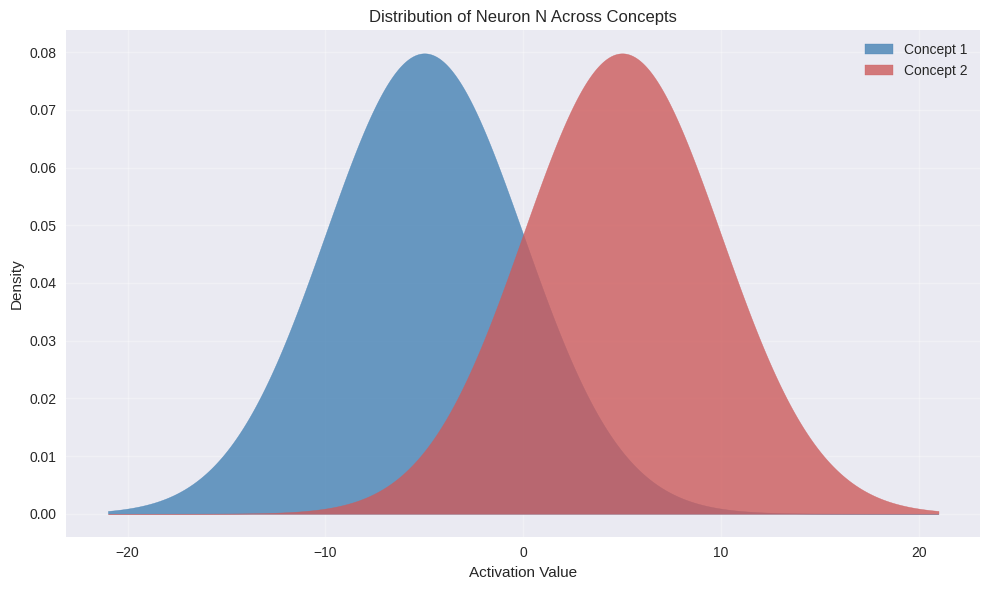

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate data points
x = np.linspace(-21, 21, 1000)
mu1, sigma1 = -5, 5 # Increased from 2.5
mu2, sigma2 = 5, 5   # Increased from 2.5

# Calculate Gaussian distributions
gaussian1 = 1/(sigma1 * np.sqrt(2 * np.pi)) * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
gaussian2 = 1/(sigma2 * np.sqrt(2 * np.pi)) * np.exp(-(x - mu2)**2 / (2 * sigma2**2))

# Colors
color1 = '#4682B4' # Steel Blue
color2 = '#CD5C5C' # Indian Red

# Create plot
plt.figure(figsize=(10, 6))
plt.fill_between(x, gaussian1, color=color1, alpha=0.8, label='Concept 1')
plt.fill_between(x, gaussian2, color=color2, alpha=0.8, label='Concept 2')

# Customize plot
plt.xlabel('Activation Value')
plt.ylabel('Density')
plt.title('Distribution of Neuron N Across Concepts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("two_normals.pdf", format="pdf", bbox_inches='tight', dpi=600)
plt.show()

IndentationError: expected an indented block (248326002.py, line 93)

In [ ]:
import importlib 
import utilities  # import the entire module
importlib.reload(utilities)
from utilities import compute_masks
for i in range(1, 21):
    per = 0.05 * i
    print(f"\nAnalysis for Percentage: {per:.2f}")
    
    # Create table for this percentage
    table = PrettyTable()
    table.field_names = ["Class", "Total Masked", "Common Zeros", "Common Zeros %"]
    
    for j in range(0, num_classes):
        # Compute masks
        mask_max, mask_std, mask_intersection, mask_max_low_std, \
        mask_max_high_std, mask_std_high_max, mask_max_random_off, \
        random_mask = compute_masks(all_fc_vals[j], per)
        
        # Calculate intersections and zeros
        intersection_zeros = (~mask_std.bool()) & (~mask_max.bool())
        num_common_zeros = intersection_zeros.sum().item()
        total_masked = int(mask_std.shape[0] - torch.count_nonzero(mask_std))
        percentage_common_zeros = num_common_zeros / total_masked
        
        # Add row to table
        table.add_row([
            j,
            total_masked,
            num_common_zeros,
            f"{percentage_common_zeros:.4f}"
        ])
    
    print(table)
    print("-" * 50)  # Separator between tables
    


Analysis for Percentage: 0.05
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      38      |      12      |     0.3158     |
|   1   |      38      |      9       |     0.2368     |
|   2   |      38      |      8       |     0.2105     |
|   3   |      38      |      9       |     0.2368     |
|   4   |      38      |      10      |     0.2632     |
|   5   |      38      |      14      |     0.3684     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.10
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      76      |      18      |     0.2368     |
|   1   |      76      |      19      |     0.2500     |
|   2   |      76      |      23

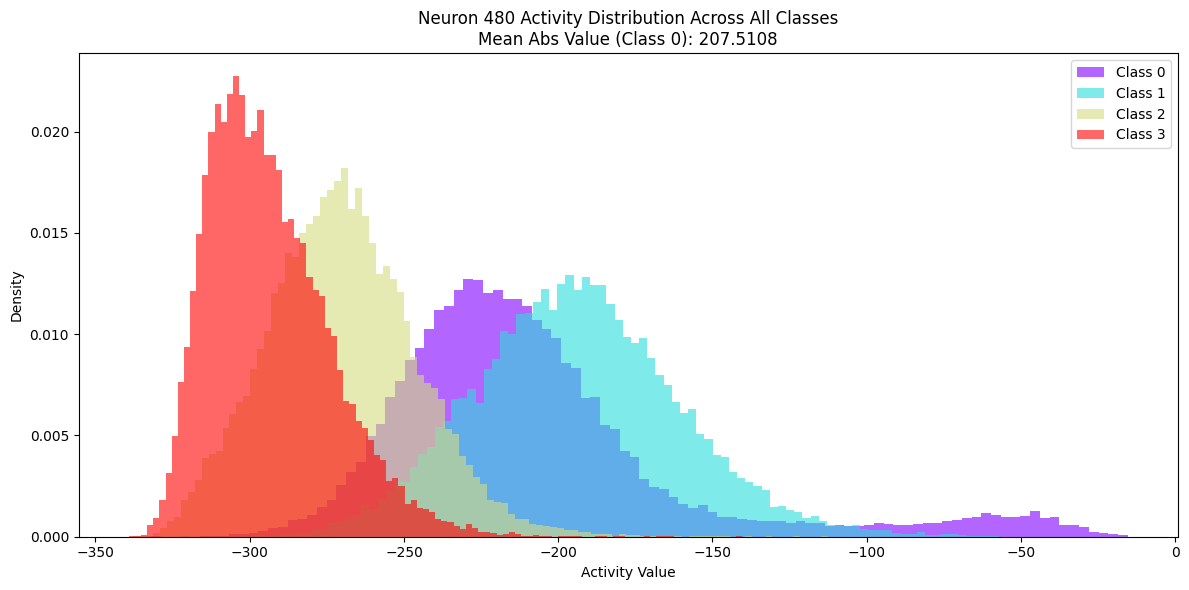

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Get mean absolute values for neurons from first class to select the neuron
fc_class0 = np.array(all_fc_vals[0])
mean_class0 = np.mean(np.abs(fc_class0), axis=0)

# Sort neurons based on class 0 mean absolute values
sorted_neurons = np.argsort(mean_class0)

# Select one of the top neurons (using the highest mean abs value neuron)
selected_neuron = 480#64,  87, 120, 232, 266, 373, 447, 480, 481

# Create figure
plt.figure(figsize=(12, 6))

# Colors for different classes
colors = plt.cm.rainbow(np.linspace(0, 1, len(all_fc_vals)))

# Plot distribution for each class
for class_idx, fc_class in enumerate(all_fc_vals):
    fc = np.array(fc_class)
    dist = [n[selected_neuron] for n in fc]
    
    plt.hist(dist, bins=100, density=True, alpha=0.6, 
             color=colors[class_idx], label=f'Class {class_idx}')

# Add title and labels
plt.title(f'Neuron {selected_neuron} Activity Distribution Across All Classes\n' + 
         f'Mean Abs Value (Class 0): {mean_class0[selected_neuron]:.4f}')
plt.xlabel('Activity Value')
plt.ylabel('Density')
plt.legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f"neuron_{selected_neuron}_all_classes.pdf", format="pdf", bbox_inches='tight', dpi=1200)

# Show plot
plt.show()

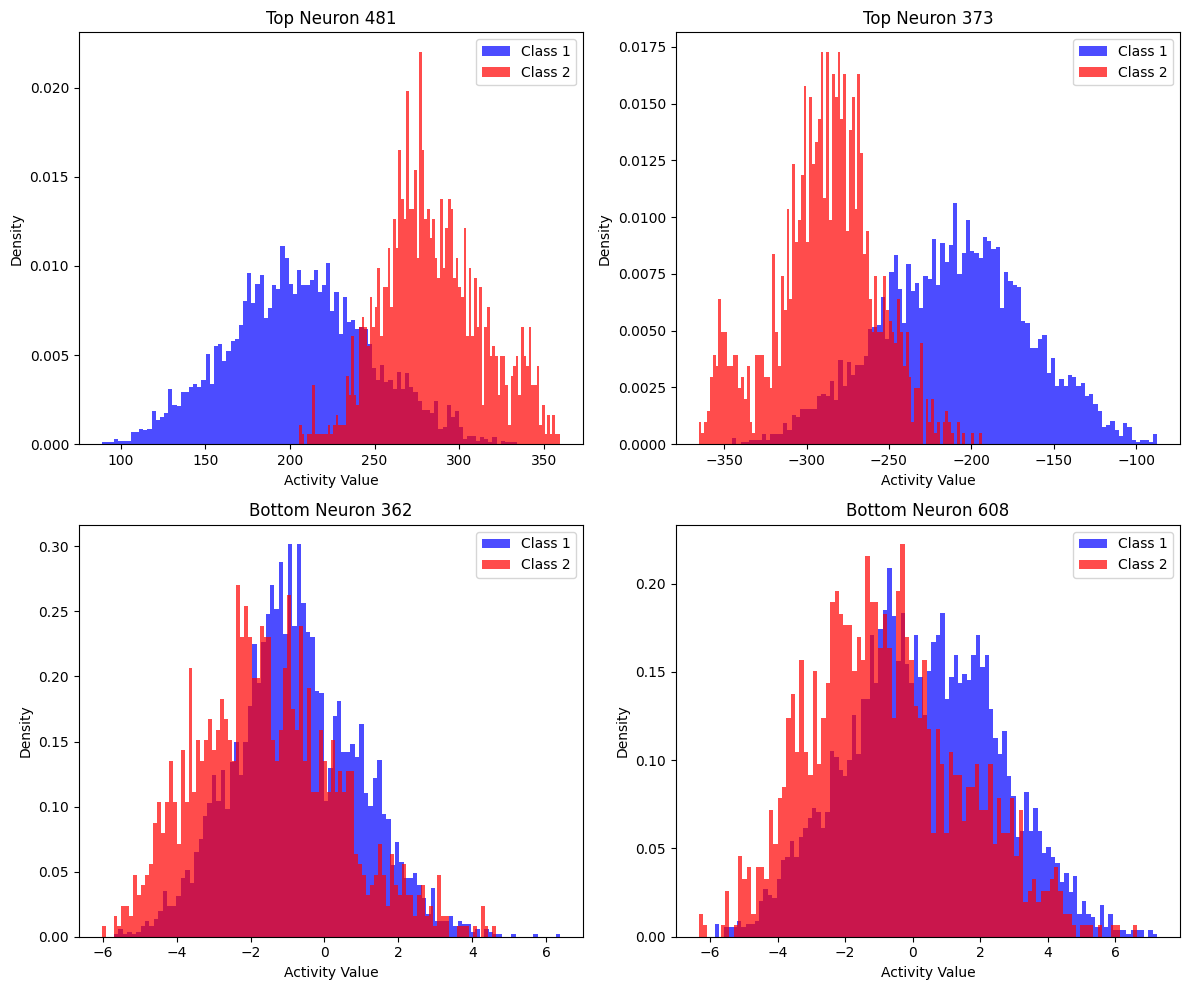

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Get mean absolute values for neurons from first class
fc_class1 = np.array(all_fc_vals[0])
mean_class1 = np.mean(np.abs(fc_class1), axis=0)

# Sort neurons based on class 1 mean absolute values
sorted_neurons = np.argsort(mean_class1)

# Get indices for top 2 and bottom 2 neurons
top_neurons = sorted_neurons[-2:]  # Top 2
bottom_neurons = sorted_neurons[:2]  # Bottom 2
selected_neurons = np.concatenate([top_neurons, bottom_neurons])

# Get activations for class 2
fc_class2 = np.array(all_fc_vals[2])

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

# Plot distributions for each selected neuron
for idx, neuron_idx in enumerate(selected_neurons):
    # Get distributions for both classes
    dist_class1 = [n[neuron_idx] for n in fc_class1]
    dist_class2 = [n[neuron_idx] for n in fc_class2]
    
    # Create histograms for both classes
    axs[idx].hist(dist_class1, bins=100, density=True, alpha=0.7, color='blue', label='Class 1')
    axs[idx].hist(dist_class2, bins=100, density=True, alpha=0.7, color='red', label='Class 2')
    
    # Add title indicating neuron index and whether it's top/bottom
    if idx < 2:
        title = f"Top Neuron {neuron_idx}"
    else:
        title = f"Bottom Neuron {neuron_idx}"
    axs[idx].set_title(title)
    
    # Add labels and legend
    axs[idx].set_xlabel('Activity Value')
    axs[idx].set_ylabel('Density')
    axs[idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save figure
plt.savefig("multiple_neuron_dist_two_classes.pdf", format="pdf", bbox_inches='tight', dpi=600)

# Show plot
plt.show()

In [10]:
dataset_names

['stanfordnlp/imdb',
 'fancyzhx/dbpedia_14',
 'dair-ai/emotion',
 'fancyzhx/ag_news',
 'stanfordnlp/sst2']

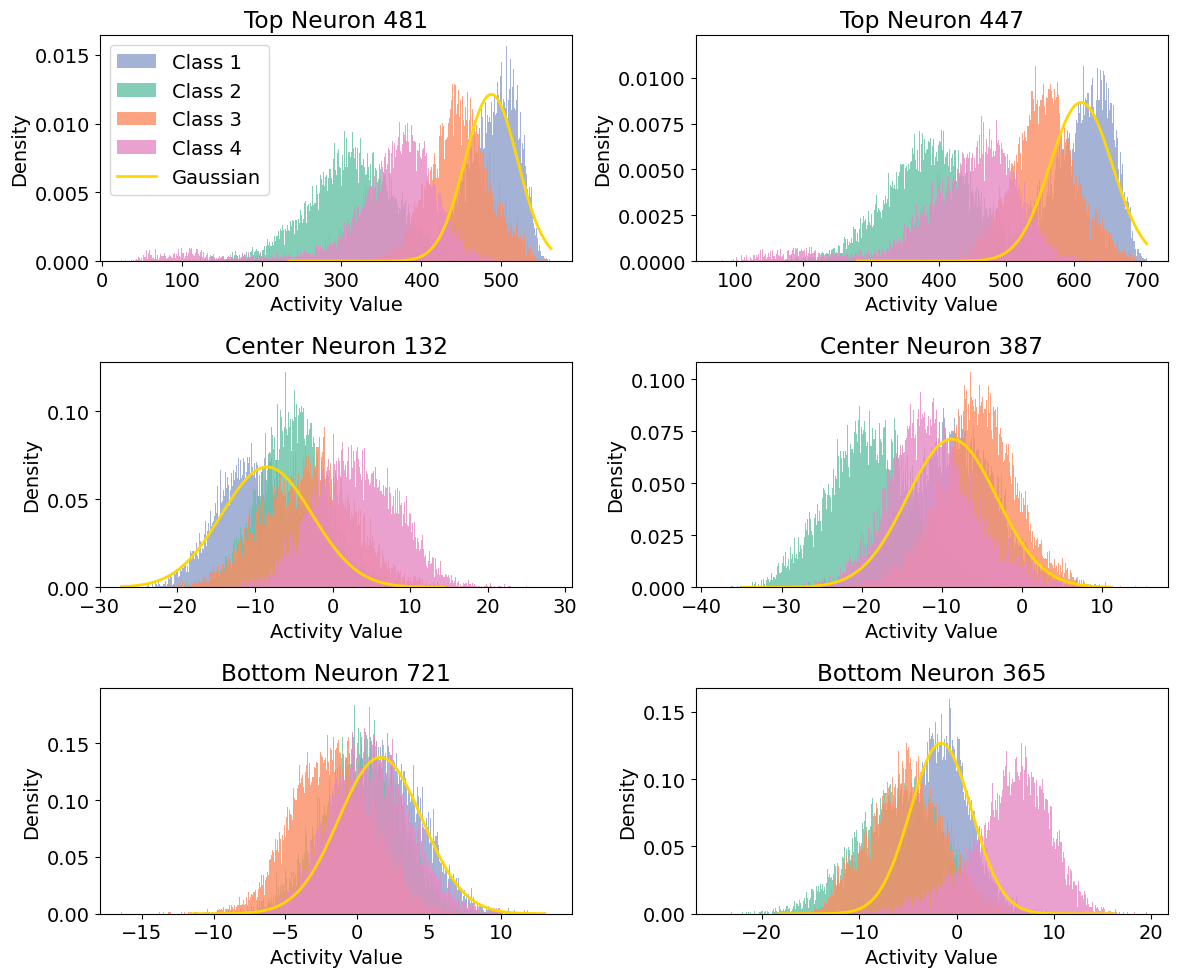

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm



all_fc_vals = dataset_fc[3]

# Get mean absolute values for neurons from first class
fc_class1 = np.array(all_fc_vals[3])
mean_class1 = np.mean(np.abs(fc_class1), axis=0)

# Sort neurons based on class 1 mean absolute values
sorted_neurons = np.argsort(mean_class1)

# Get indices for top 2 and bottom 2 neurons
top_neurons = sorted_neurons[-2:]  # Top 2
center_neurons = sorted_neurons[int(mean_class1.shape[0]/2):int(mean_class1.shape[0]/2)+2]  # Center 2
bottom_neurons = sorted_neurons[:2]  # Bottom 2
selected_neurons = np.concatenate([top_neurons, center_neurons , bottom_neurons])

# Get activations for class 2
fc_class2 = np.array(all_fc_vals[1])
fc_class3 = np.array(all_fc_vals[2])
fc_class4 = np.array(all_fc_vals[0])

# Create figure with 2x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()
colors = sns.color_palette("Set2", n_colors=4)
# Define colors with good contrast
hist_color1 = '#4682B4'  # Steel Blue
hist_color2 = '#CD5C5C'  # Indian Red
curve_color1 = '#FFD700'  # Gold
curve_color2 = '#32CD32'  # Lime Green

# Plot distributions for each selected neuron
for idx, neuron_idx in enumerate(selected_neurons):
    # Get distributions for both classes
    dist_class1 = [n[neuron_idx] for n in fc_class1]
    dist_class2 = [n[neuron_idx] for n in fc_class2]
    dist_class3 = [n[neuron_idx] for n in fc_class3]
    dist_class4 = [n[neuron_idx] for n in fc_class4]
    
    # Create histograms for both classes
    axs[idx].hist(dist_class1, bins=1000, density=True, alpha=0.8, color=colors[2], 
                  label='Class 1' if idx == 0 else None)
    axs[idx].hist(dist_class2, bins=1000, density=True, alpha=0.8, color=colors[0], 
                  label='Class 2' if idx == 0 else None)
    axs[idx].hist(dist_class3, bins=1000, density=True, alpha=0.8, color=colors[1],#'#9370DB',
                    label='Class 3' if idx == 0 else None)
    axs[idx].hist(dist_class4, bins=1000, density=True, alpha=0.8, color=colors[3],#'#2E8B57',
                    label='Class 4' if idx == 0 else None)
    
    # Fit and plot Gaussian curves for both classes
    # Class 1
    mu1, std1 = norm.fit(dist_class1)
    x1 = np.linspace(min(dist_class1), max(dist_class1), 100)
    p1 = norm.pdf(x1, mu1, std1)
    axs[idx].plot(x1, p1, color=curve_color1, linewidth=2, 
                  label='Gaussian' if idx == 0 else None)
    
    # # Class 2
    # mu2, std2 = norm.fit(dist_class2)
    # x2 = np.linspace(min(dist_class2), max(dist_class2), 100)
    # p2 = norm.pdf(x2, mu2, std2)
    # axs[idx].plot(x2, p2, color=curve_color1, linewidth=2)
    
    # # Class 3
    # mu3, std3 = norm.fit(dist_class3)
    # x3 = np.linspace(min(dist_class3), max(dist_class3), 100)
    # p3 = norm.pdf(x3, mu3, std3)
    # axs[idx].plot(x3, p3, color=curve_color1, linewidth=2)
    
    # # Class 4
    # mu4, std4 = norm.fit(dist_class4)
    # x4 = np.linspace(min(dist_class4), max(dist_class4), 100)
    # p4 = norm.pdf(x4, mu4, std4)
    # axs[idx].plot(x4, p4, color=curve_color1, linewidth=2)
    
    
    # Add title indicating neuron index and whether it's top/bottom
    if idx < 2:
        title = f"Top Neuron {neuron_idx}"
        
    elif idx < 4 and idx >= 2:
        title = f"Center Neuron {neuron_idx}"
    else:
        title = f"Bottom Neuron {neuron_idx}"
    axs[idx].set_title(title)
    
    # Add labels
    axs[idx].set_xlabel('Activity Value')
    axs[idx].set_ylabel('Density')
    
    # Only add legend to the first subplot
    if idx == 0:
        axs[idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save figure
plt.savefig("multiple_neuron_dist_all_classes.pdf", format="pdf", bbox_inches='tight', dpi=600)

# Show plot
plt.show()

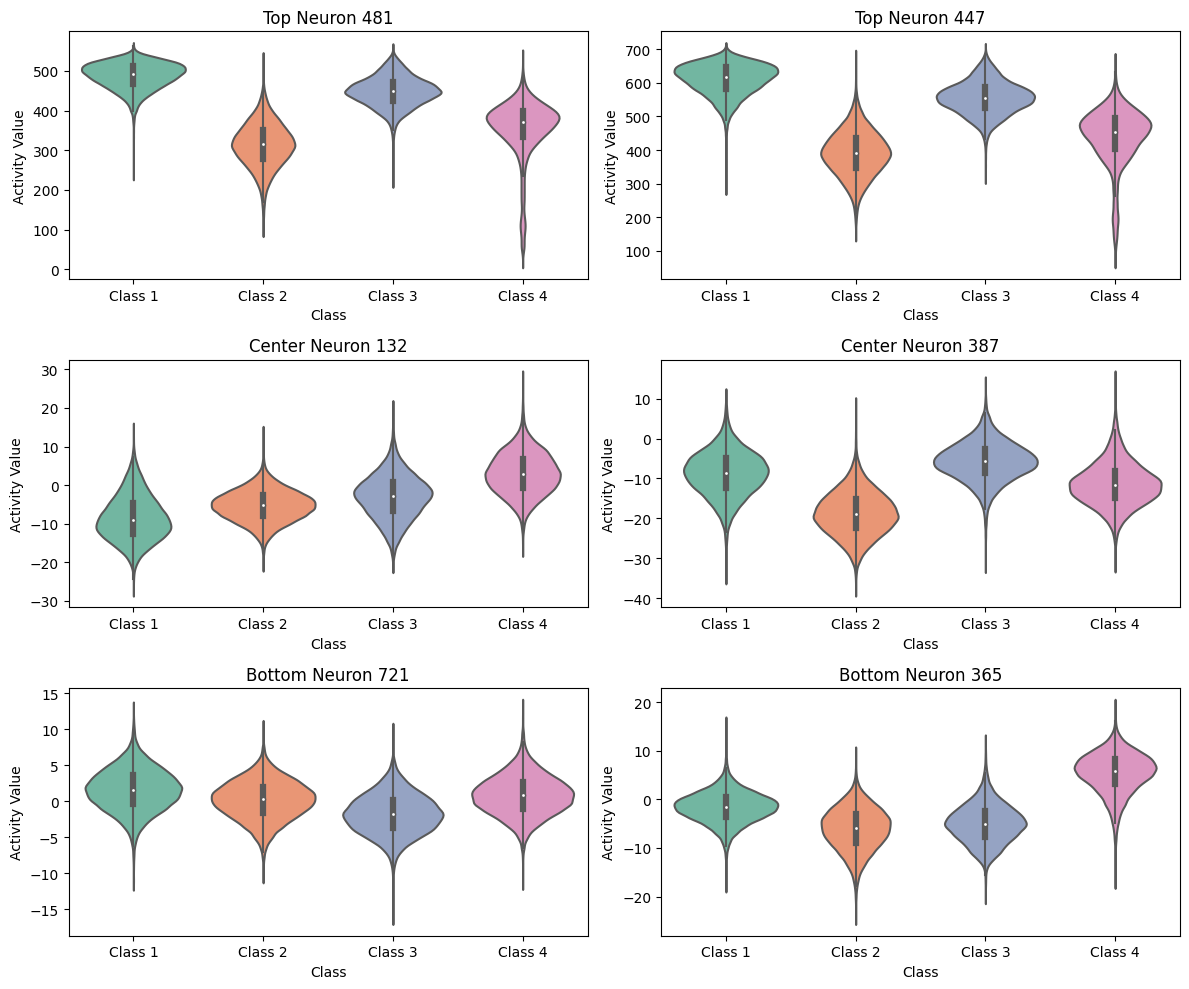

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keep the initial setup for selected_neurons

all_fc_vals = dataset_fc[0]
fc_class1 = np.array(all_fc_vals[3])
mean_class1 = np.mean(np.abs(fc_class1), axis=0)
sorted_neurons = np.argsort(mean_class1)
top_neurons = sorted_neurons[-2:]
center_neurons = sorted_neurons[int(mean_class1.shape[0]/2):int(mean_class1.shape[0]/2)+2]
bottom_neurons = sorted_neurons[:2]
selected_neurons = np.concatenate([top_neurons, center_neurons, bottom_neurons])

# Get activations for all classes
fc_class2 = np.array(all_fc_vals[1])
fc_class3 = np.array(all_fc_vals[2])
fc_class4 = np.array(all_fc_vals[0])

# Create figure with 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()
colors = sns.color_palette("Set2", n_colors=4)

# Plot distributions for each selected neuron
for idx, neuron_idx in enumerate(selected_neurons):
    # Get distributions for all classes
    dist_class1 = [n[neuron_idx] for n in fc_class1]
    dist_class2 = [n[neuron_idx] for n in fc_class2]
    dist_class3 = [n[neuron_idx] for n in fc_class3]
    dist_class4 = [n[neuron_idx] for n in fc_class4]
    
    # Prepare data for violin plot
    data_to_plot = [dist_class1, dist_class2, dist_class3, dist_class4]
    
    # Create violin plot
    sns.violinplot(data=data_to_plot, ax=axs[idx], palette=colors)
    
    # Add title indicating neuron index and whether it's top/bottom/center
    if idx < 2:
        title = f"Top Neuron {neuron_idx}"
    elif idx < 4:
        title = f"Center Neuron {neuron_idx}"
    else:
        title = f"Bottom Neuron {neuron_idx}"
    axs[idx].set_title(title)
    
    # Add labels
    axs[idx].set_xlabel('Class')
    axs[idx].set_ylabel('Activity Value')
    
    # Set x-tick labels
    axs[idx].set_xticklabels(['Class 1', 'Class 2', 'Class 3', 'Class 4'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save figure
plt.savefig("multiple_neuron_violin_all_classes.pdf", format="pdf", bbox_inches='tight', dpi=600)

# Show plot
plt.show()

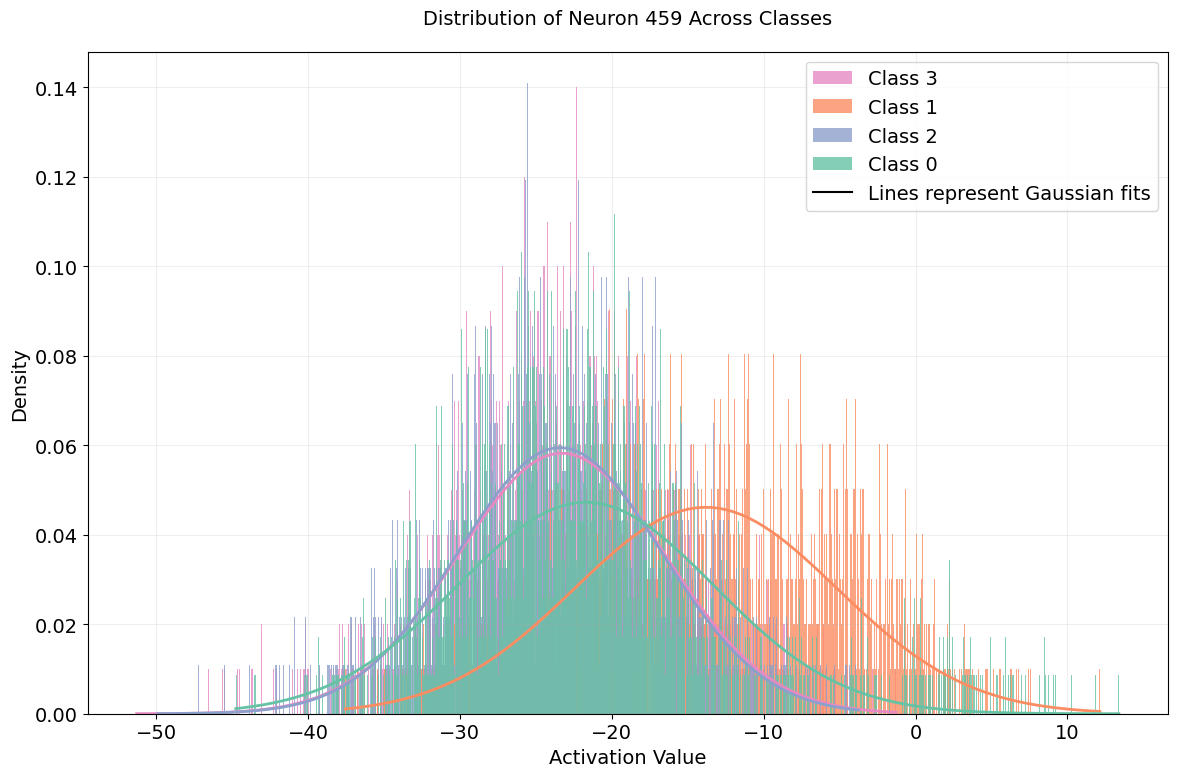

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_neuron_distribution(all_fc_vals, neuron_idx):
    """
    Plot the distribution of a specific neuron's activations across all classes.
    
    Parameters:
    all_fc_vals (list): List of lists containing activation values for each class
    neuron_idx (int): Index of the neuron to analyze
    """
    # Set global font size
    plt.rcParams.update({'font.size': 14})
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Define colors for each class
    num_classes = len(all_fc_vals)
    colors = sns.color_palette("Set2", n_colors=4)
    
    # Plot distributions for all classes
    for class_idx in [3,1,2,0]:
        # Get current class data
        class_data = np.array(all_fc_vals[class_idx])
        dist_class = [n[neuron_idx] for n in class_data]
        
        # Create histogram for current class
        plt.hist(dist_class, 
                bins=1000, 
                density=True, 
                alpha=0.8, 
                color=colors[class_idx], 
                label=f'Class {class_idx}')
        
        # Fit and plot Gaussian curve
        mu, std = norm.fit(dist_class)
        x = np.linspace(min(dist_class), max(dist_class), 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 
                color=colors[class_idx], 
                linewidth=2, 
                linestyle='-')
    
    # Add empty plot with dashed line for legend explanation
    plt.plot([], [], 
            color='black', 
            linestyle='-', 
            label='Lines represent Gaussian fits')
    
    # Add labels and title
    plt.xlabel('Activation Value', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Distribution of Neuron {neuron_idx} Across Classes', 
              fontsize=14, 
              pad=20)
    
    # Add legend with adjusted font size
    plt.legend(fontsize=14)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.2)
    
    # Set tick label font sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"neuron_{neuron_idx}_all_classes.pdf", format="pdf", bbox_inches='tight', dpi=600)
    return plt


# neuron_ids = [ 32,  64,  87, 266, 373, 447, 480, 481, 573, 582, 633, 640, 675]


# for neuron_id in neuron_ids:
#     plot_neuron_distribution(all_fc_vals, neuron_id).show()172, 459, 512, 334, 250
plot_neuron_distribution(all_fc_vals, 459).show()#[  3,   7,  13,  32,  40,  89,  94, 103, 111, 118, 156, 174, 181,
        # 191, 213, 252, 265, 268, 294, 306, 314, 328, 358, 363, 374, 410,
        # 438, 477, 479, 508, 514, 523, 535, 546, 586, 590, 599, 617, 640,
        # 669, 692, 701, 729, 756]

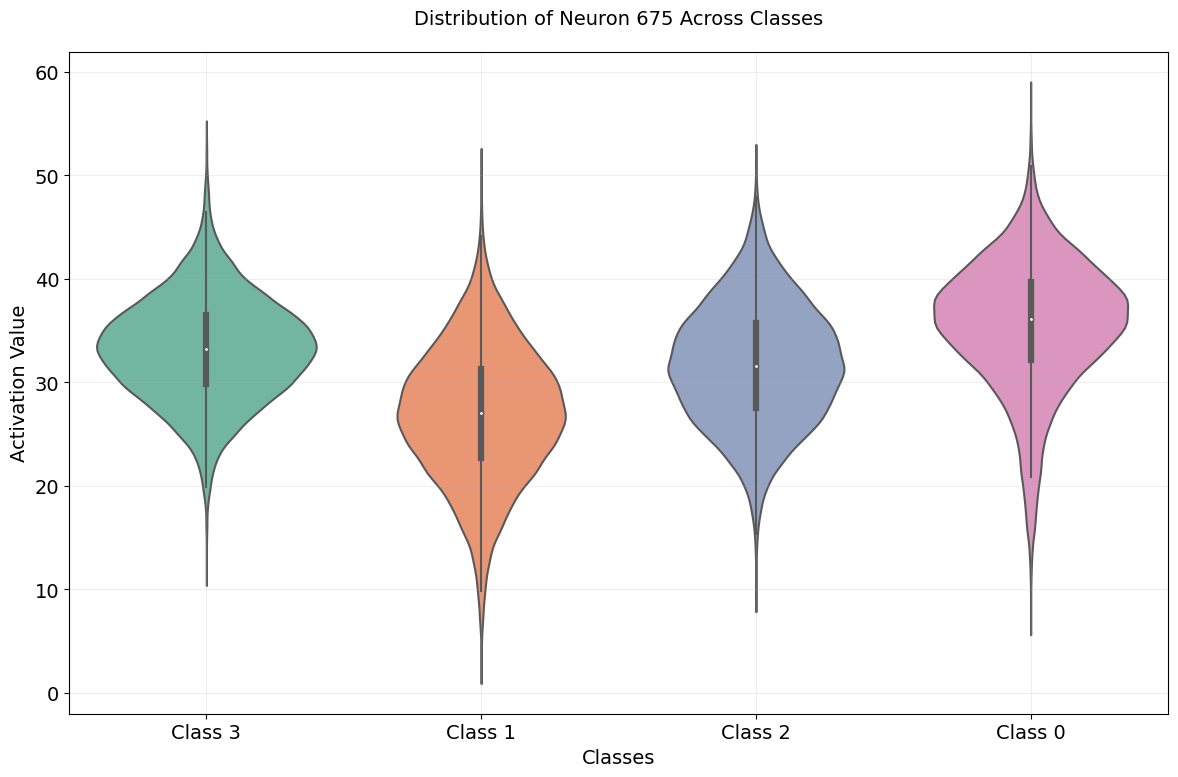

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_neuron_distribution(all_fc_vals, neuron_idx):
    """
    Plot the distribution of a specific neuron's activations across all classes using violin plots.
    
    Parameters:
    all_fc_vals (list): List of lists containing activation values for each class
    neuron_idx (int): Index of the neuron to analyze
    """
    # Set global font size
    plt.rcParams.update({'font.size': 14})
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Prepare data for violin plot
    data_to_plot = []
    labels = []
    
    # Collect data for all classes in desired order [3,1,2,0]
    for class_idx in [3,1,2,0]:
        class_data = np.array(all_fc_vals[class_idx])
        dist_class = [n[neuron_idx] for n in class_data]
        data_to_plot.append(dist_class)
        labels.extend([f'Class {class_idx}'] * len(dist_class))
    
    # Create violin plot
    sns.violinplot(data=data_to_plot, 
                  palette=sns.color_palette("Set2", n_colors=4),
                  inner='box')  # 'box' shows quartile boxes inside violin
    
    # Add labels and title
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Activation Value', fontsize=14)
    plt.title(f'Distribution of Neuron {neuron_idx} Across Classes', 
              fontsize=14, 
              pad=20)
    
    # Set x-tick labels
    plt.xticks(range(4), [f'Class {i}' for i in [3,1,2,0]], fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.2)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"neuron_{neuron_idx}_violin_all_classes.pdf", format="pdf", bbox_inches='tight', dpi=600)
    return plt

# Use the function
plot_neuron_distribution(all_fc_vals, 675).show()

In [80]:
mask_all = []
for fc_vals in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max,mask_max_random_off, mask_random = compute_masks(fc_vals, 0.05)
    
    mask_all.append(~mask_max.bool().numpy())

In [81]:
mask_all = np.array(mask_all)

# mask_all = mask_all.sum(axis=0)

# np.where(mask_all==4)



In [122]:
all_fc_vals.append([val for sublist in all_fc_vals for val in sublist])

In [168]:
import utilities
importlib.reload(utilities)
from utilities import compute_avg_std, compute_masks
for fc_vals in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max,mask_max_random_off, mask_random = compute_masks(fc_vals, 0.2)
    
    print("Average: ", compute_avg_std(fc_vals,~mask_max_low_std.bool()))

Average:  5.48443
Average:  5.6513147
Average:  5.146653
Average:  6.6799574
Average:  8.059241
Average:  8.340233
Average:  6.6965027


In [163]:
from utilities import compute_avg_std, compute_masks
for fc_vals in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max,mask_max_random_off, mask_random = compute_masks(fc_vals, 0.2)
    
    print("Average: ", compute_avg_std(fc_vals,~mask_max.bool()))

Average:  7.18825
Average:  5.879981
Average:  6.386847
Average:  7.0686164
Average:  8.922268
Average:  10.106986
Average:  9.503306


In [143]:
intersection_zeros = (~mask_std.bool()) & (~mask_max.bool())
num_common_zeros = intersection_zeros.sum().item()

In [145]:
num_common_zeros

164

Plot saved to class_statistics.pdf


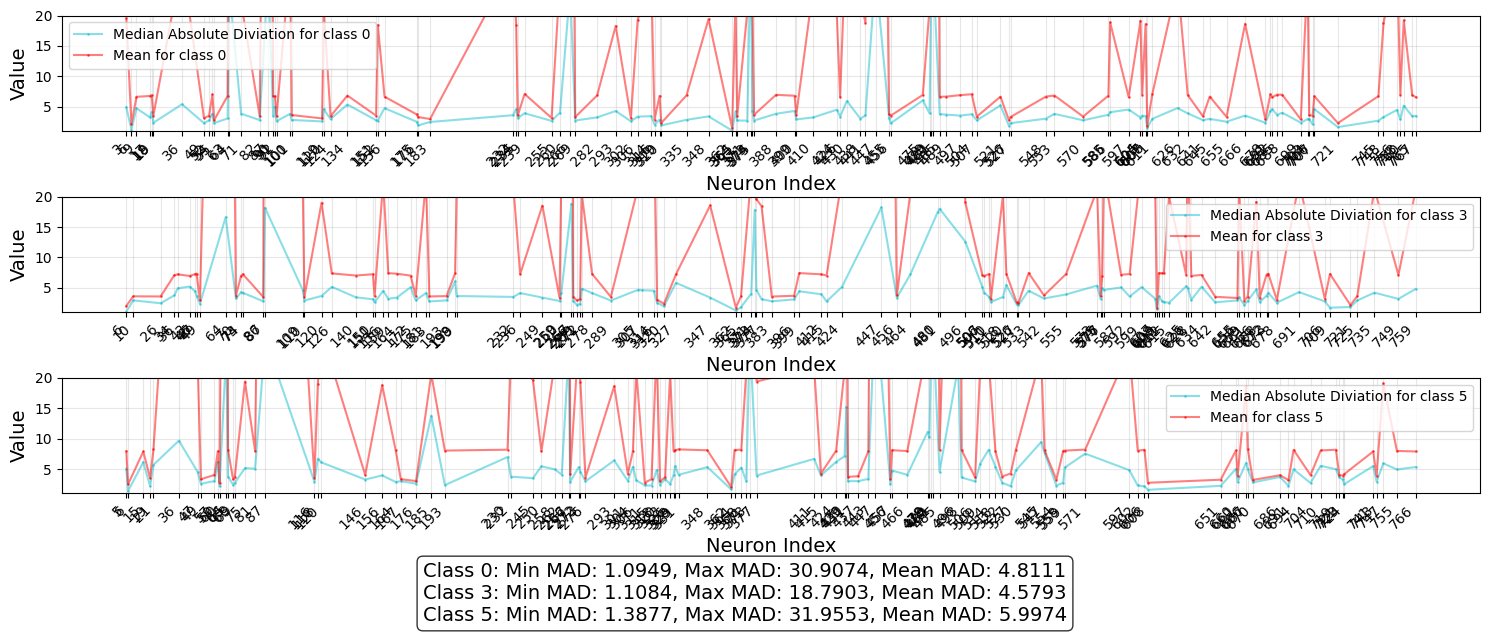

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def mad(data):
    median = np.median(data, axis=0)
    deviations = np.abs(data - median)
    mad_value = np.median(deviations, axis=0)
    return mad_value

def z_score(data):
    
    #4200,768
    """
    Calculate z-scores along axis 0 (columns) of a 2D array.
    
    Parameters:
    data : numpy.ndarray
        2D input array where rows are observations and columns are features
        
    Returns:
    numpy.ndarray
        Array of same shape as input with z-scores calculated for each column
    """
    # Calculate mean along axis 0
    mean = np.mean(data, axis=0)
    
    #768
    
    # Calculate standard deviation along axis 0
    std = np.std(data, axis=0, ddof=1)  # ddof=1 for sample standard deviation
    
    # Avoid division by zero
    # std = np.where(std == 0, 1, std)
    
    # Calculate z-scores
    
    # 4200,768
    z_scores = (data - mean) / std
    z_scores = np.mean(z_scores, axis=0)
    
    return z_scores

def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Calculate number of rows and columns for subplots
    n_rows = (num_classes + 2) // 1  # 3 plots per row
    n_cols = min(1, num_classes)
    
    # Create figure
    fig = plt.figure(figsize=(15, 2 * n_rows + 2))  # Added extra height for stats
    x = np.arange(num_neurons)

    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i=0
    for class_idx, class_features in enumerate(all_fc_vals):
        
        if class_idx in [0,3,5]:
            
            ax = plt.subplot(n_rows, n_cols, i + 1)
            i+=1
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            
            mean = np.mean(np.abs(class_features), axis=0)
            
            indices_top = np.argsort(mean)[:int(768*0.05)]
            
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            
            selected_indices.sort()
            
            std_dev = std_dev[selected_indices]
            
            variance = variance[selected_indices]
            
            mean = mean[selected_indices]
            
            xi = x[selected_indices]
            
            # Store statistics for later
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(xi, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(xi, std_dev, 
                    label=f'Median Absolute Diviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(xi, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Customize subplot
            # ax.set_title(f'Class {class_idx}')
            ax.set_xlabel('Neuron Index', fontsize=14)
            ax.set_ylabel('Value', fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits if needed
            ax.set_ylim(1, 20)
            ax.set_xticks(xi)
            ax.set_xticklabels(xi, rotation=45, ha='right')

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box at the bottom
    summary_text = '\n'.join(stats_text)
    # flag = False
    # for text in stats_text:
    #     if flag:
    #         summary_text += text + '\n'
    #         flag = False
    #     else:
    #         summary_text += text + ','
    #         flag = True
            
    summary_text = summary_text.strip('\n')
        
    fig.text(0.5, 0.65, summary_text,
             ha='center',
             va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    # Add padding at the bottom for stats
    plt.subplots_adjust(bottom=0.1 + 0.02*num_classes)  # Adjust based on number of classes
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

# Example usage:
fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

In [14]:
all_fc_vals = all_fc_vals[:6]

flattened = [val for sublist in all_fc_vals for val in sublist]
all_fc_vals.append(flattened)

In [21]:
len(all_fc_vals[4])

1726

Plot saved to class_statistics.pdf


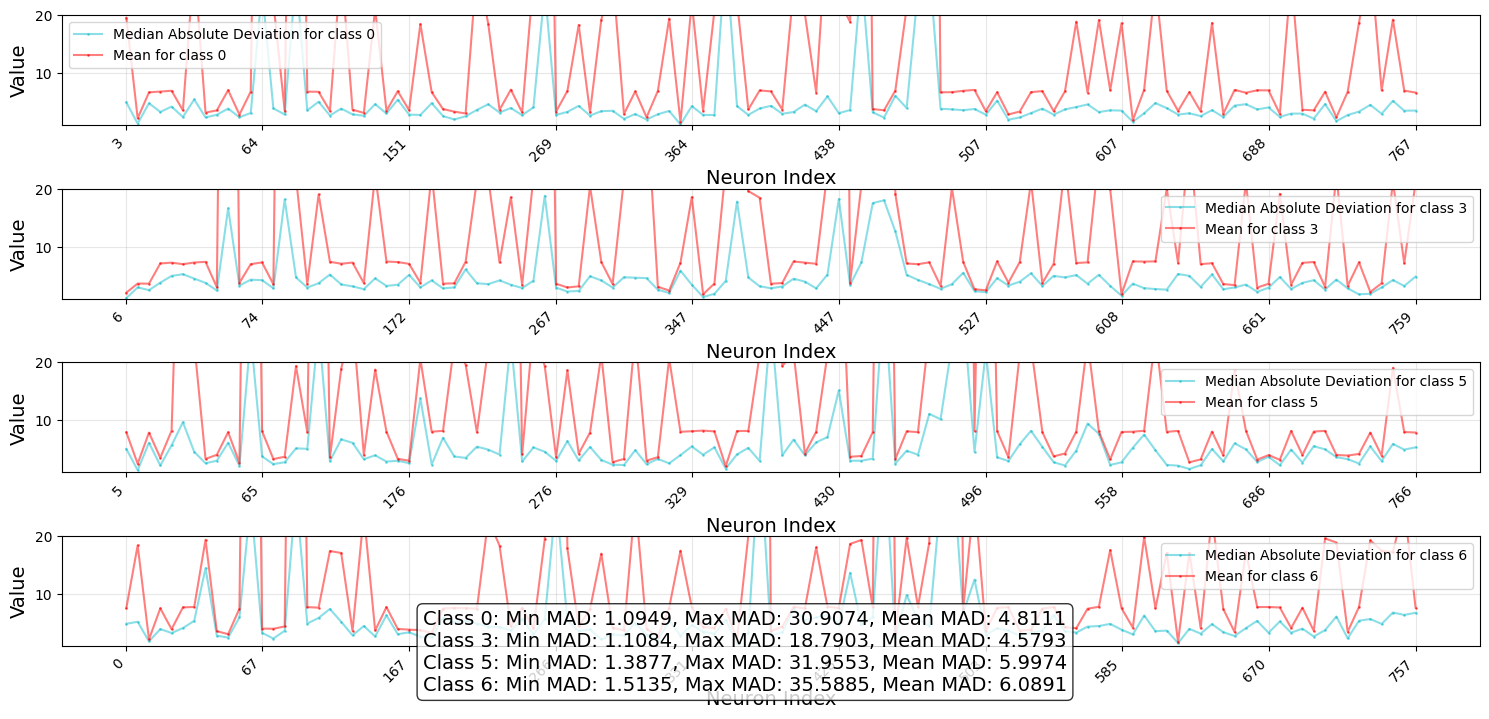

In [22]:
# all_fc_vals.append([val for sublist in all_fc_vals for val in sublist])

def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Calculate number of rows and columns for subplots
    n_rows = (num_classes + 2) // 1
    n_cols = min(1, num_classes)
    
    # Create figure
    fig = plt.figure(figsize=(15, 2 * n_rows + 2))
    x = np.arange(num_neurons)

    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i = 0
    for class_idx, class_features in enumerate(all_fc_vals):
        if class_idx in [0, 3, 5, 6]:
            ax = plt.subplot(n_rows, n_cols, i + 1)
            i += 1
            
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            mean = np.mean(np.abs(class_features), axis=0)
            
            # Select indices for top, bottom, and middle portions
            indices_top = np.argsort(mean)[:int(768*0.05)]
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            selected_indices.sort()
            
            # Apply selection to statistics
            std_dev = std_dev[selected_indices]
            variance = variance[selected_indices]
            mean = mean[selected_indices]
            
            # Create evenly spaced x positions for plotting
            x_plot = np.arange(len(selected_indices))
            
            # Store statistics
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(x_plot, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(x_plot, std_dev, 
                    label=f'Median Absolute Deviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(x_plot, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Customize subplot
            ax.set_xlabel('Neuron Index', fontsize=14)
            ax.set_ylabel('Value', fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits
            ax.set_ylim(1, 20)
            
            # Set evenly spaced x-ticks with original indices as labels
            num_ticks = min(10, len(selected_indices))  # Limit number of ticks for readability
            tick_positions = np.linspace(0, len(selected_indices)-1, num_ticks, dtype=int)
            ax.set_xticks(tick_positions)
            ax.set_xticklabels([selected_indices[pos] for pos in tick_positions],
                             rotation=45, ha='right')

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box
    summary_text = '\n'.join(stats_text)
    fig.text(0.5, 0.65, summary_text,
             ha='center',
             va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), 
             fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1 + 0.02*num_classes)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

# Example usage:
fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

NameError: name 'mad' is not defined

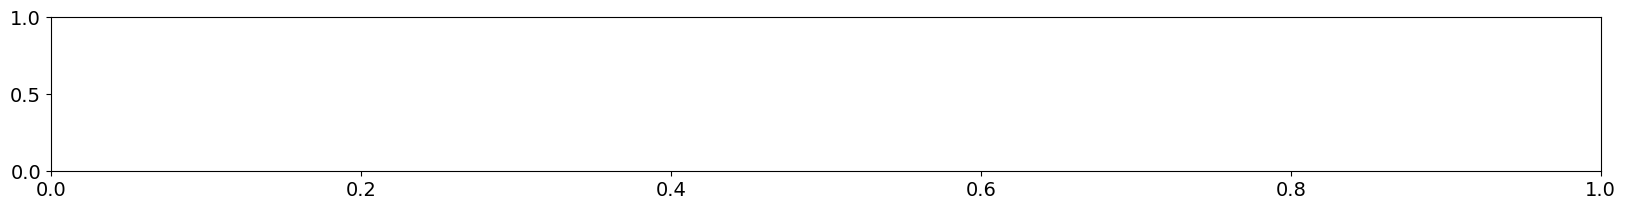

In [85]:
def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Calculate number of rows and columns for subplots
    n_rows = (num_classes + 2) // 1
    n_cols = min(1, num_classes)
    
    # Create figure with increased width
    fig = plt.figure(figsize=(20, 2 * n_rows + 2))  # Increased width from 15 to 20
    x = np.arange(num_neurons)

    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i = 0
    for class_idx, class_features in enumerate(all_fc_vals):
        if class_idx in [0, 3, 5]:
            ax = plt.subplot(n_rows, n_cols, i + 1)
            i += 1
            
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            mean = np.mean(np.abs(class_features), axis=0)
            
            # Select indices for top, bottom, and middle portions
            indices_top = np.argsort(mean)[:int(768*0.05)]
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            selected_indices.sort()
            
            # Apply selection to statistics
            std_dev = std_dev[selected_indices]
            variance = variance[selected_indices]
            mean = mean[selected_indices]
            
            # Create evenly spaced x positions for plotting
            x_plot = np.arange(len(selected_indices))
            
            # Store statistics
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(x_plot, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(x_plot, std_dev, 
                    label=f'Median Absolute Deviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(x_plot, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Customize subplot
            ax.set_xlabel('Neuron Index', fontsize=14)
            ax.set_ylabel('Value', fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits
            ax.set_ylim(1, 20)
            
            # Show all selected indices on x-axis
            ax.set_xticks(x_plot)
            ax.set_xticklabels(selected_indices, rotation=90, ha='right')
            
            # Adjust subplot to give more room for x-axis labels
            plt.subplots_adjust(bottom=0.2)

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box
    summary_text = '\n'.join(stats_text)
    fig.text(0.5, 0.63, summary_text,
             ha='center',
             va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), 
             fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2, right=0.95)  # Increased bottom margin for labels
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

Plot saved to class_statistics.pdf


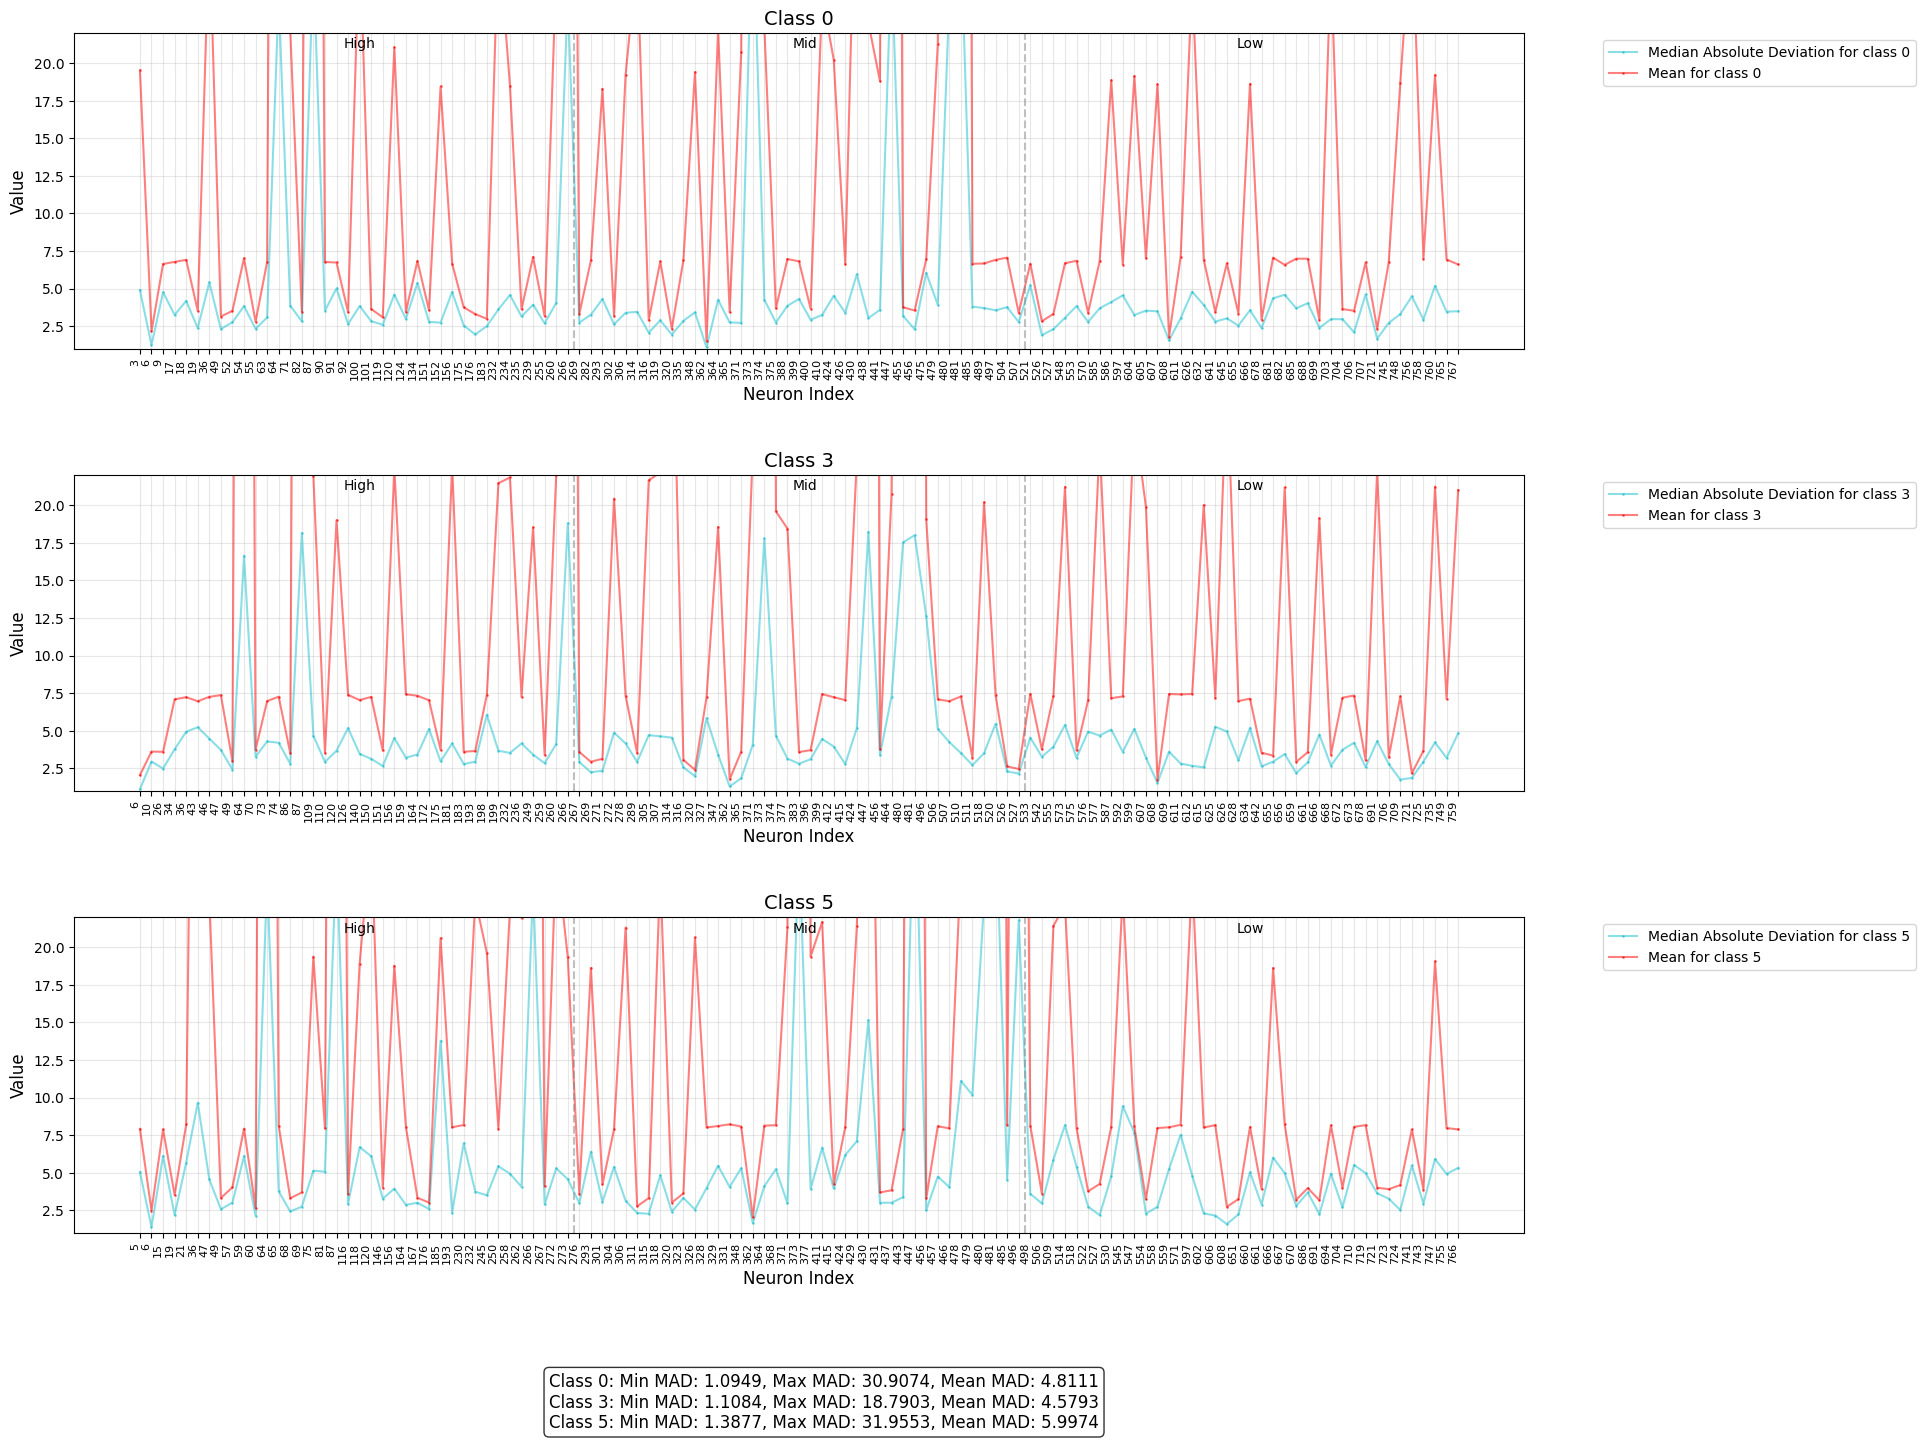

In [35]:
def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))  # Increased height
    
    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i = 0
    for class_idx, class_features in enumerate(all_fc_vals):
        if class_idx in [0, 3, 5]:
            ax = plt.subplot(3, 1, i + 1)  # Changed to 3,1 for better spacing
            i += 1
            
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            mean = np.mean(np.abs(class_features), axis=0)
            
            # Select indices for top, bottom, and middle portions
            indices_top = np.argsort(mean)[:int(768*0.05)]
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            selected_indices.sort()
            
            # Apply selection to statistics
            std_dev = std_dev[selected_indices]
            variance = variance[selected_indices]
            mean = mean[selected_indices]
            
            # Create evenly spaced x positions for plotting
            x_plot = np.arange(len(selected_indices))
            
            # Find positions for dividers
            high_end = len(indices_top)
            mid_start = high_end
            mid_end = high_end + len(indices_middle)
            
            # Store statistics
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(x_plot, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(x_plot, std_dev, 
                    label=f'Median Absolute Deviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(x_plot, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Add vertical dividers
            ax.axvline(x=high_end - 0.5, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=mid_end - 0.5, color='gray', linestyle='--', alpha=0.5)
            
            # Add region labels
            ax.text(high_end/2, 21, 'High', ha='center')
            ax.text((mid_start + mid_end)/2, 21, 'Mid', ha='center')
            ax.text((mid_end + len(selected_indices))/2, 21, 'Low', ha='center')
            
            # Customize subplot
            ax.set_xlabel('Neuron Index', fontsize=12)
            ax.set_ylabel('Value', fontsize=12)
            ax.set_title(f'Class {class_idx}', fontsize=14)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits with extra space for labels
            ax.set_ylim(1, 22)  # Increased to make room for labels
            
            # Show all selected indices on x-axis
            ax.set_xticks(x_plot)
            ax.set_xticklabels(selected_indices, rotation=90, ha='right', fontsize=8)

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box at the bottom
    plt.figtext(0.5, 0.02, '\n'.join(stats_text),
                ha='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=12)
    
    # Adjust layout
    plt.subplots_adjust(right=0.85,  # Make room for legend
                       bottom=0.15,   # Make room for stats text
                       top=0.95,      # Reduce top margin
                       hspace=0.4)    # Add space between subplots
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

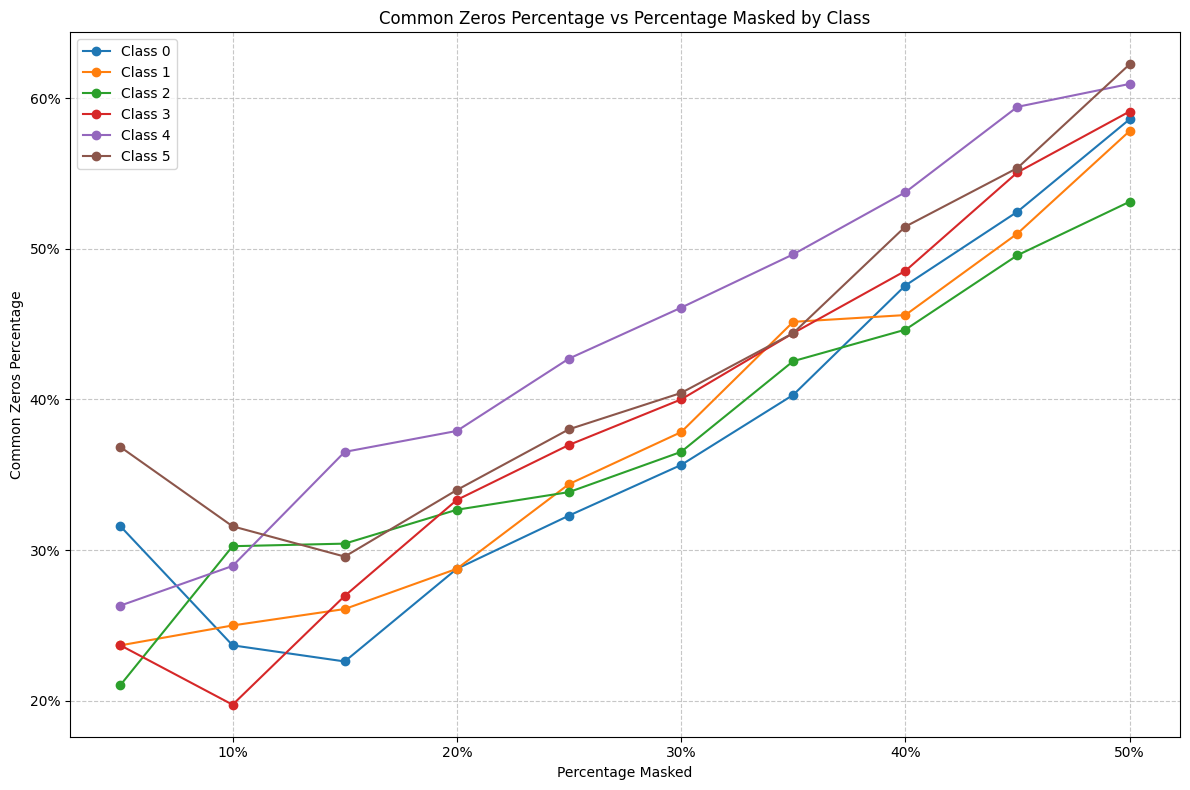

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Function to extract data from text
def extract_data(text):
    # Initialize lists to store data
    percentages = []
    classes = []
    common_zeros_percentages = []
    
    # Extract data using regular expressions
    current_percentage = None
    for line in text.split('\n'):
        # Get percentage from header
        if "Analysis for Percentage:" in line:
            current_percentage = float(re.search(r"(\d+\.\d+)", line).group(1))
        
        # Get class data from table rows
        if re.match(r"\|\s*\d+\s*\|", line):
            parts = line.split('|')
            if len(parts) >= 5:
                class_num = int(parts[1].strip())
                common_zeros_pct = float(parts[4].strip())
                
                percentages.append(current_percentage)
                classes.append(class_num)
                common_zeros_percentages.append(common_zeros_pct)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Percentage_Masked': percentages,
        'Class': classes,
        'Common_Zeros_Percentage': common_zeros_percentages
    })
    
    return df

# Create the visualization
def plot_data(df):
    plt.figure(figsize=(12, 8))
    
    # Plot line for each class
    for class_num in sorted(df['Class'].unique()):
        class_data = df[df['Class'] == class_num]
        plt.plot(
            class_data['Percentage_Masked'],
            class_data['Common_Zeros_Percentage'],
            marker='o',
            label=f'Class {class_num}'
        )
    
    plt.xlabel('Percentage Masked')
    plt.ylabel('Common Zeros Percentage')
    plt.title('Common Zeros Percentage vs Percentage Masked by Class')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Convert x-axis to percentage format
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Example usage
# Assuming your text is stored in a variable called 'text':
text = '''Analysis for Percentage: 0.05
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      38      |      12      |     0.3158     |
|   1   |      38      |      9       |     0.2368     |
|   2   |      38      |      8       |     0.2105     |
|   3   |      38      |      9       |     0.2368     |
|   4   |      38      |      10      |     0.2632     |
|   5   |      38      |      14      |     0.3684     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.10
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      76      |      18      |     0.2368     |
|   1   |      76      |      19      |     0.2500     |
|   2   |      76      |      23      |     0.3026     |
|   3   |      76      |      15      |     0.1974     |
|   4   |      76      |      22      |     0.2895     |
|   5   |      76      |      24      |     0.3158     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.15
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     115      |      26      |     0.2261     |
|   1   |     115      |      30      |     0.2609     |
|   2   |     115      |      35      |     0.3043     |
|   3   |     115      |      31      |     0.2696     |
|   4   |     115      |      42      |     0.3652     |
|   5   |     115      |      34      |     0.2957     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.20
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     153      |      44      |     0.2876     |
|   1   |     153      |      44      |     0.2876     |
|   2   |     153      |      50      |     0.3268     |
|   3   |     153      |      51      |     0.3333     |
|   4   |     153      |      58      |     0.3791     |
|   5   |     153      |      52      |     0.3399     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.25
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     192      |      62      |     0.3229     |
|   1   |     192      |      66      |     0.3438     |
|   2   |     192      |      65      |     0.3385     |
|   3   |     192      |      71      |     0.3698     |
|   4   |     192      |      82      |     0.4271     |
|   5   |     192      |      73      |     0.3802     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.30
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     230      |      82      |     0.3565     |
|   1   |     230      |      87      |     0.3783     |
|   2   |     230      |      84      |     0.3652     |
|   3   |     230      |      92      |     0.4000     |
|   4   |     230      |     106      |     0.4609     |
|   5   |     230      |      93      |     0.4043     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.35
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     268      |     108      |     0.4030     |
|   1   |     268      |     121      |     0.4515     |
|   2   |     268      |     114      |     0.4254     |
|   3   |     268      |     119      |     0.4440     |
|   4   |     268      |     133      |     0.4963     |
|   5   |     268      |     119      |     0.4440     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.40
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     307      |     146      |     0.4756     |
|   1   |     307      |     140      |     0.4560     |
|   2   |     307      |     137      |     0.4463     |
|   3   |     307      |     149      |     0.4853     |
|   4   |     307      |     165      |     0.5375     |
|   5   |     307      |     158      |     0.5147     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.45
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     345      |     181      |     0.5246     |
|   1   |     345      |     176      |     0.5101     |
|   2   |     345      |     171      |     0.4957     |
|   3   |     345      |     190      |     0.5507     |
|   4   |     345      |     205      |     0.5942     |
|   5   |     345      |     191      |     0.5536     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.50
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     384      |     225      |     0.5859     |
|   1   |     384      |     222      |     0.5781     |
|   2   |     384      |     204      |     0.5312     |
|   3   |     384      |     227      |     0.5911     |
|   4   |     384      |     234      |     0.6094     |
|   5   |     384      |     239      |     0.6224     |
+-------+--------------+--------------+----------------+
--------------------------------------------------
'''


df = extract_data(text)
plt = plot_data(df)
plt.show()


Spearman Correlation Results:
  Class  Spearman Correlation      P-Value
Class 0              0.915152 2.044724e-04
Class 1              1.000000 6.646897e-64
Class 2              1.000000 6.646897e-64
Class 3              0.987879 9.307460e-08
Class 4              1.000000 6.646897e-64
Class 5              0.915152 2.044724e-04


<Figure size 640x480 with 0 Axes>

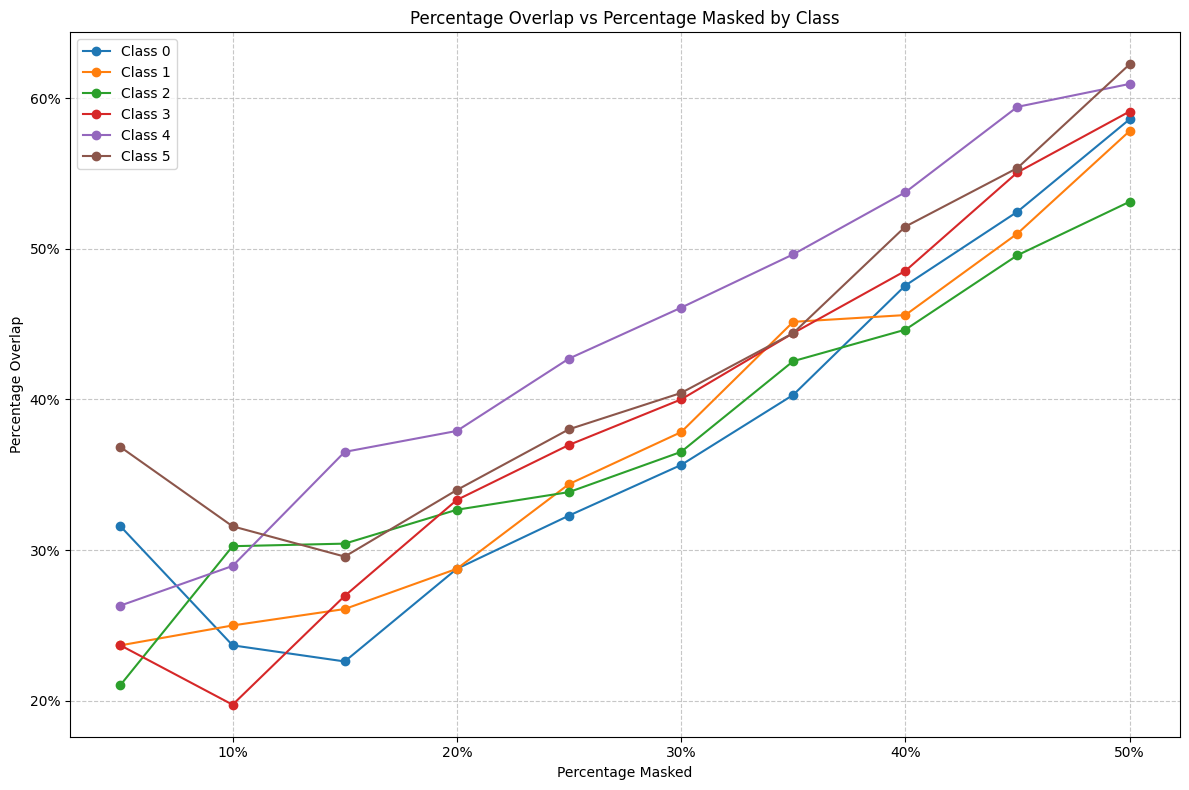

<Figure size 640x480 with 0 Axes>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy import stats
import seaborn as sns
import numpy as np

# Function to extract data from text
def extract_data(text):
    # Initialize lists to store data
    percentages = []
    classes = []
    common_zeros_percentages = []
    
    # Extract data using regular expressions
    current_percentage = None
    for line in text.split('\n'):
        # Get percentage from header
        if "Analysis for Percentage:" in line:
            current_percentage = float(re.search(r"(\d+\.\d+)", line).group(1))
        
        # Get class data from table rows
        if re.match(r"\|\s*\d+\s*\|", line):
            parts = line.split('|')
            if len(parts) >= 5:
                class_num = int(parts[1].strip())
                common_zeros_pct = float(parts[4].strip())
                
                percentages.append(current_percentage)
                classes.append(class_num)
                common_zeros_percentages.append(common_zeros_pct)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Percentage_Masked': percentages,
        'Class': classes,
        'Common_Zeros_Percentage': common_zeros_percentages
    })
    
    return df

# Create the visualization
def plot_data(df):
    plt.figure(figsize=(12, 8))
    
    # Plot line for each class
    for class_num in sorted(df['Class'].unique()):
        class_data = df[df['Class'] == class_num]
        plt.plot(
            class_data['Percentage_Masked'],
            class_data['Common_Zeros_Percentage'],
            marker='o',
            label=f'Class {class_num}'
        )
    
    plt.xlabel('Percentage Masked')
    plt.ylabel('Percentage Overlap')
    plt.title('Percentage Overlap vs Percentage Masked by Class')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Convert x-axis to percentage format
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

def calculate_spearman_correlation(df):
    # Calculate Spearman correlation for each class
    correlations = {}
    p_values = {}
    
    for class_num in sorted(df['Class'].unique()):
        class_data = df[df['Class'] == class_num]
        correlation, p_value = stats.spearmanr(
            class_data['Percentage_Masked'],
            class_data['Common_Zeros_Percentage']
        )
        correlations[f'Class {class_num}'] = correlation
        p_values[f'Class {class_num}'] = p_value
    
    # Create correlation DataFrame
    correlation_df = pd.DataFrame({
        'Class': list(correlations.keys()),
        'Spearman Correlation': list(correlations.values()),
        'P-Value': list(p_values.values())
    })
    
    return correlation_df

def plot_correlation_heatmap(df):
    # Pivot the data to create a correlation matrix
    pivot_df = df.pivot(index='Class', columns='Percentage_Masked', values='Common_Zeros_Percentage')
    
    # Calculate correlation matrix
    corr_matrix = pivot_df.corr(method='spearman')
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Spearman Correlation Heatmap between Classes')
    plt.tight_layout()
    
    return plt

# Example usage
# Assuming your text is stored in a variable called 'text':
df = extract_data(text)

# Calculate and display Spearman correlations
correlation_results = calculate_spearman_correlation(df)
print("\nSpearman Correlation Results:")
print(correlation_results.to_string(index=False))

# Create visualizations
plot_data(df)
plt.savefig('common_zeros_plot.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.figure()
# plot_correlation_heatmap(df)
# plt.show()


Spearman Correlation between Percentage Masked and Overlap Percentage:
Correlation coefficient: 0.9299
P-value: 7.1850e-27


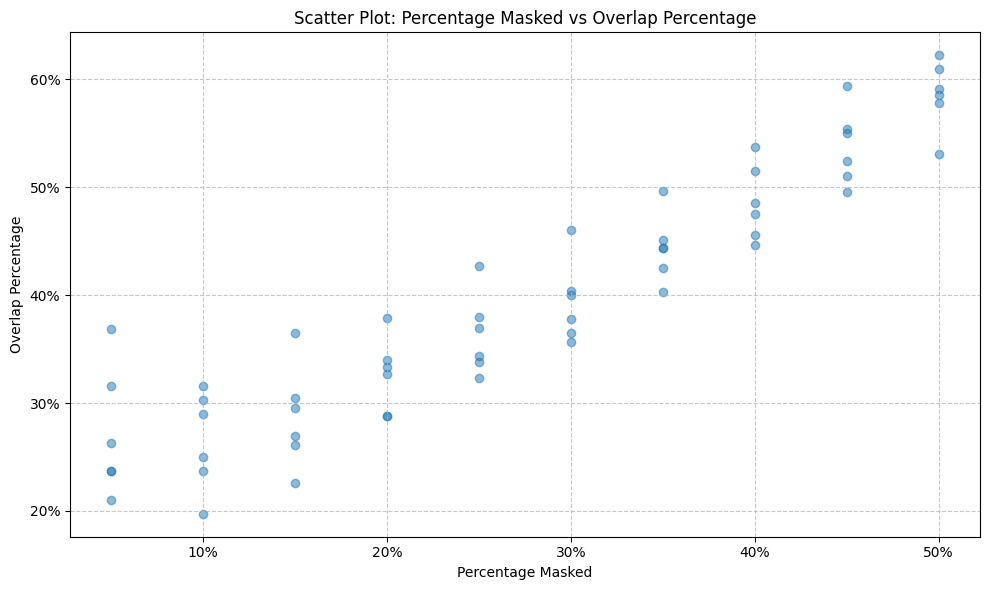

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re

def extract_data(text):
    # Initialize lists to store data
    percentages = []
    common_zeros_percentages = []
    
    # Extract data using regular expressions
    current_percentage = None
    for line in text.split('\n'):
        # Get percentage from header
        if "Analysis for Percentage:" in line:
            current_percentage = float(re.search(r"(\d+\.\d+)", line).group(1))
        
        # Get class data from table rows
        if re.match(r"\|\s*\d+\s*\|", line):
            parts = line.split('|')
            if len(parts) >= 5:
                common_zeros_pct = float(parts[4].strip())
                
                percentages.append(current_percentage)
                common_zeros_percentages.append(common_zeros_pct)
    
    return percentages, common_zeros_percentages

def calculate_correlation(text):
    # Get data
    percentages, common_zeros_percentages = extract_data(text)
    
    # Calculate Spearman correlation
    correlation, p_value = stats.spearmanr(percentages, common_zeros_percentages)
    
    # Print results
    print(f"\nSpearman Correlation between Percentage Masked and Overlap Percentage:")
    print(f"Correlation coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(percentages, common_zeros_percentages, alpha=0.5)
    plt.xlabel('Percentage Masked')
    plt.ylabel('Overlap Percentage')
    plt.title('Scatter Plot: Percentage Masked vs Overlap Percentage')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Convert axes to percentage format
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    plt.tight_layout()
    plt.show()

# Run analysis
calculate_correlation(text)

/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


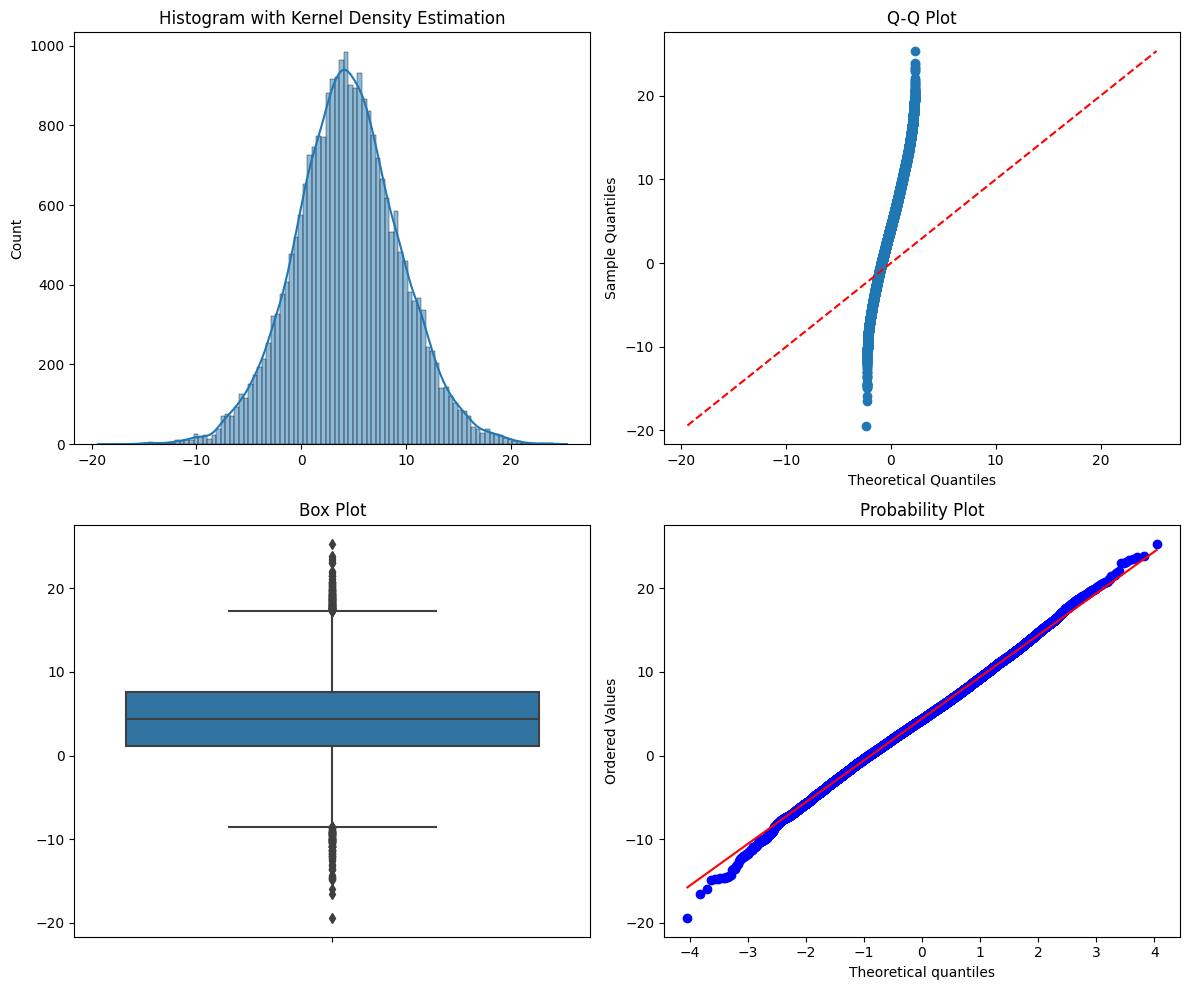

Normality Test Results

1. Descriptive Statistics:
   - Mean: 4.4104
   - Median: 4.3388
   - Standard Deviation: 4.9943
   - Skewness: 0.0250
   - Kurtosis: 0.3040

2. Shapiro-Wilk Test:
   - Statistic: 0.9989
   - p-value: 0.0000
   - Normal distribution: False

3. D'Agostino-Pearson Test:
   - Statistic: 77.5602
   - p-value: 0.0000
   - Normal distribution: False

4. Anderson-Darling Test:
   - Statistic: 7.5243
   - Critical Values:
     15.0%: 0.5760
     10.0%: 0.6560
     5.0%: 0.7870
     2.5%: 0.9180
     1.0%: 1.0920
   - Normal distribution: False



In [41]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, shapiro, anderson

def test_normality(data, alpha=0.05):
    """
    Comprehensive normality testing of data using multiple methods.
    
    Parameters:
    -----------
    data : array-like
        The data to be tested for normality
    alpha : float
        Significance level for hypothesis tests (default: 0.05)
        
    Returns:
    --------
    dict
        Dictionary containing test results and descriptive statistics
    """
    results = {}
    
    # 1. Descriptive Statistics
    results['descriptive'] = {
        'mean': np.mean(data),
        'median': np.median(data),
        'std': np.std(data),
        'skewness': stats.skew(data),
        'kurtosis': stats.kurtosis(data)
    }
    
    # 2. Shapiro-Wilk Test
    # Best for sample sizes < 2000
    shapiro_stat, shapiro_p = stats.shapiro(data)
    results['shapiro'] = {
        'statistic': shapiro_stat,
        'p_value': shapiro_p,
        'is_normal': shapiro_p > alpha
    }
    
    # 3. D'Agostino-Pearson Test
    # Tests for skewness and kurtosis
    k2_stat, k2_p = stats.normaltest(data)
    results['dagostino'] = {
        'statistic': k2_stat,
        'p_value': k2_p,
        'is_normal': k2_p > alpha
    }
    
    # 4. Anderson-Darling Test
    anderson_result = anderson(data)
    results['anderson'] = {
        'statistic': anderson_result.statistic,
        'critical_values': anderson_result.critical_values,
        'significance_levels': anderson_result.significance_level,
        'is_normal': anderson_result.statistic < anderson_result.critical_values[2]  # Using 5% significance level
    }
    
    # 5. QQ Plot Data
    theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(data)))
    ordered_data = np.sort(data)
    results['qq_plot'] = {
        'theoretical': theoretical_quantiles,
        'ordered_data': ordered_data
    }
    
    return results

def plot_normality_tests(data, results):
    """
    Create visualization plots for normality assessment.
    
    Parameters:
    -----------
    data : array-like
        The data being tested
    results : dict
        Results from test_normality function
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histogram with KDE
    sns.histplot(data, kde=True, ax=axes[0,0])
    axes[0,0].set_title('Histogram with Kernel Density Estimation')
    
    # 2. Q-Q Plot
    axes[0,1].scatter(results['qq_plot']['theoretical'], 
                     results['qq_plot']['ordered_data'])
    axes[0,1].plot([np.min(data), np.max(data)], 
                   [np.min(data), np.max(data)], 
                   'r--')
    axes[0,1].set_title('Q-Q Plot')
    axes[0,1].set_xlabel('Theoretical Quantiles')
    axes[0,1].set_ylabel('Sample Quantiles')
    
    # 3. Box Plot
    sns.boxplot(y=data, ax=axes[1,0])
    axes[1,0].set_title('Box Plot')
    
    # 4. Probability Plot
    stats.probplot(data, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Probability Plot')
    
    plt.tight_layout()
    return fig

def generate_report(results):
    """
    Generate a detailed report of normality test results.
    
    Parameters:
    -----------
    results : dict
        Results from test_normality function
        
    Returns:
    --------
    str
        Formatted report string
    """
    report = []
    report.append("Normality Test Results\n=====================\n")
    
    # Descriptive Statistics
    report.append("1. Descriptive Statistics:")
    desc = results['descriptive']
    report.append(f"   - Mean: {desc['mean']:.4f}")
    report.append(f"   - Median: {desc['median']:.4f}")
    report.append(f"   - Standard Deviation: {desc['std']:.4f}")
    report.append(f"   - Skewness: {desc['skewness']:.4f}")
    report.append(f"   - Kurtosis: {desc['kurtosis']:.4f}\n")
    
    # Shapiro-Wilk Test
    report.append("2. Shapiro-Wilk Test:")
    report.append(f"   - Statistic: {results['shapiro']['statistic']:.4f}")
    report.append(f"   - p-value: {results['shapiro']['p_value']:.4f}")
    report.append(f"   - Normal distribution: {results['shapiro']['is_normal']}\n")
    
    # D'Agostino-Pearson Test
    report.append("3. D'Agostino-Pearson Test:")
    report.append(f"   - Statistic: {results['dagostino']['statistic']:.4f}")
    report.append(f"   - p-value: {results['dagostino']['p_value']:.4f}")
    report.append(f"   - Normal distribution: {results['dagostino']['is_normal']}\n")
    
    # Anderson-Darling Test
    report.append("4. Anderson-Darling Test:")
    report.append(f"   - Statistic: {results['anderson']['statistic']:.4f}")
    report.append("   - Critical Values:")
    for sig_level, crit_val in zip(results['anderson']['significance_levels'],
                                 results['anderson']['critical_values']):
        report.append(f"     {sig_level}%: {crit_val:.4f}")
    report.append(f"   - Normal distribution: {results['anderson']['is_normal']}\n")
    
    return "\n".join(report)

# Example usage:
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(42)
    
    #select a random number from 0-768
    
    neuron = 3
    
    
    
    data = np.array(all_fc_vals[0])
    
    sample_data = data[:,neuron]
    
    # Run tests
    results = test_normality(sample_data)
    
    # Generate plots
    plot_normality_tests(sample_data, results)
    plt.show()
    
    # Print report
    print(generate_report(results))

In [9]:
data.shape

(25500, 768)

In [12]:
from scipy.stats import anderson

neuron = 1

sample_data = data[:,neuron]
 
result = anderson(sample_data, dist='norm')
print(f"Anderson-Darling Test Statistic: {result.statistic}")
for i, sig in enumerate(result.significance_level):
    print(f"Significance Level: {sig}% - Critical Value: {result.critical_values[i]}")

Anderson-Darling Test Statistic: 13.689606966039719
Significance Level: 15.0% - Critical Value: 0.576
Significance Level: 10.0% - Critical Value: 0.656
Significance Level: 5.0% - Critical Value: 0.787
Significance Level: 2.5% - Critical Value: 0.918
Significance Level: 1.0% - Critical Value: 1.092


In [22]:
i = 0

data = np.array(all_fc_vals[2])
for neuron in range(768):
    sample_data = data[:,neuron]
    
    stat, p = shapiro(sample_data)
    # print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")
    
    if p > 0.05:
        # print("Data appears to be normally distributed (fail to reject H0).")
        i+=1
        
print(i)

2


In [15]:
i

2

In [40]:
from scipy.stats import skew, kurtosis

sk = 0
total_kurtosis = 0
for neuron in range(768):
    sample_data = data[:,0]
    # print("Skewness:", skew(sample_data))
    # print("Kurtosis:", kurtosis(sample_data))
    kurtosis_value = kurtosis(sample_data, fisher=False)
    sk += skew(sample_data)
    total_kurtosis += kurtosis_value
    # print("Kurtosis:", kurtosis_value)
    
print(total_kurtosis/768, sk/768)

2.9259155670494432 0.45859289626180716


In [43]:
from scipy.stats import jarque_bera

jb = 0
p = 0

for neuron in range(768):
    sample_data = data[:,neuron]
    result = jarque_bera(sample_data)
    jb += result.statistic
    p += result.pvalue
    # print("Jarque-Bera Statistic:", result.statistic)
    # print("p-value:", result.pvalue)
    
print(jb/768, p/768)

1299.8182135253937 0.0051384279380830905


In [ ]:
from scipy.stats import kstest


i = 0

data = np.array(all_fc_vals[0])
for neuron in range(768):
    sample_data = data[:,neuron]
    stat, p = kstest(sample_data, 'norm', args=(np.mean(sample_data), np.std(sample_data)))
    # print(f"Kolmogorov-Smirnov Test Statistic: {stat}, p-value: {p}")
    
    if p > 0.005:
        # print("Data appears to be normally distributed (fail to reject H0).")
        i+=1
    # else:
    #     print(neuron)
print(i)

88


In [63]:
from scipy.stats import normaltest

i = 0
for neuron in range(768):
    sample_data = data[:,neuron]
    sample_data = (sample_data - np.mean(sample_data)) / np.std(sample_data)    
    stat, p = normaltest(sample_data)
    if p > 0.05:
        i+=1
print(i)

12


In [ ]:
from statsmodels.stats.diagnostic import lilliefors
stat, p = lilliefors(data)
if p > 0.05:
    print("Data appears to be normally distributed (fail to reject H0).")
else:
    print("Data does not appear to be normally distributed (reject H0).")

In [60]:
import numpy as np
from scipy.stats import skew, kurtosis, normaltest, shapiro

def test_neuron_normality(data):
    n_neurons = data.shape[1]
    
    # Initialize statistics
    total_skew = 0
    total_kurtosis = 0
    shapiro_pvals = []
    normal_pvals = []
    
    # Test each neuron
    for neuron in range(n_neurons):
        neuron_data = data[:, neuron]
        
        
        neuron_data = (neuron_data - np.mean(neuron_data)) / np.std(neuron_data)
        # Basic statistics
        total_skew += skew(neuron_data)
        total_kurtosis += kurtosis(neuron_data, fisher=False)  # fisher=False for Pearson's definition
        
        # Statistical tests
        _, shapiro_p = shapiro(neuron_data)
        _, normal_p = normaltest(neuron_data)  # D'Agostino and Pearson's test
        
        shapiro_pvals.append(shapiro_p)
        normal_pvals.append(normal_p)
    
    # Average statistics
    avg_skew = total_skew / n_neurons
    avg_kurtosis = total_kurtosis / n_neurons
    
    # Count how many neurons pass normality tests (p > 0.05)
    shapiro_normal = sum(p > 0.05 for p in shapiro_pvals)
    dagostino_normal = sum(p > 0.05 for p in normal_pvals)
    
    print(f"Average Skewness: {avg_skew:.4f}")
    print(f"Average Kurtosis: {avg_kurtosis:.4f}")
    print(f"Neurons passing Shapiro-Wilk: {shapiro_normal}/{n_neurons}")
    print(f"Neurons passing D'Agostino-Pearson: {dagostino_normal}/{n_neurons}")

# Usage
test_neuron_normality(data)

/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Average Skewness: 0.0067
Average Kurtosis: 3.3789
Neurons passing Shapiro-Wilk: 2/768
Neurons passing D'Agostino-Pearson: 12/768


In [65]:
from scipy import stats

def test_practical_normality(data, effect_size=0.1):
    """
    Test if the distribution is normal within a practical effect size
    effect_size: maximum allowed difference (default 0.1 = 10%)
    """
    n_neurons = data.shape[1]
    practical_normal = 0
    
    for neuron in range(n_neurons):
        neuron_data = data[:, neuron]
        # Normalize data
        normalized_data = (neuron_data - np.mean(neuron_data)) / np.std(neuron_data)
        # Run KS test against standard normal
        ks_stat, _ = stats.kstest(normalized_data, 'norm')
        
        if ks_stat < effect_size:  # Maximum difference is less than effect_size
            practical_normal += 1
    
    return practical_normal, n_neurons

for data in all_fc_vals:
    print(test_practical_normality(np.array(data)))


(756, 768)
(768, 768)
(768, 768)
(755, 768)


In [59]:
def equivalence_test_normality(data, epsilon=0.1):
    """
    Test if the distribution is equivalent to normal within epsilon
    epsilon: maximum allowed difference from normal parameters
    """
    n_neurons = data.shape[1]
    equivalent_normal = 0
    
    for neuron in range(n_neurons):
        neuron_data = data[:, neuron]
        # Calculate mean and std
        mu = np.mean(neuron_data)
        sigma = np.std(neuron_data)
        
        # Test if empirical quantiles are within epsilon of theoretical
        quantiles = np.percentile(neuron_data, [2.5, 25, 50, 75, 97.5])
        theoretical = stats.norm.ppf([0.025, 0.25, 0.5, 0.75, 0.975], mu, sigma)
        
        if np.all(np.abs(quantiles - theoretical) / sigma < epsilon):
            equivalent_normal += 1
    
    return equivalent_normal, n_neurons

print(equivalence_test_normality(data))

(247, 768)


[3 2 0 1]
Commo|n nuerons [640, 389, 6, 266, 650, 141, 526, 17, 401, 767, 22, 535, 157, 32, 288, 547, 548, 549, 675, 41, 425, 50, 696, 700, 573, 447, 64, 322, 67, 707, 582, 202, 330, 717, 718, 82, 468, 85, 87, 599, 219, 480, 481, 617, 235, 373, 633, 126, 127]
[17, 373, 235, 447, 288, 6, 700, 202, 549, 650]
[17, 373, 235, 447, 288, 6, 700, 202, 549, 650]
[17, 373, 235, 447, 288, 6, 700, 202, 549, 650]
[17, 373, 235, 447, 288, 6, 700, 202, 549, 650]
[17, 373, 235, 447, 288, 6, 700, 202, 549, 650]


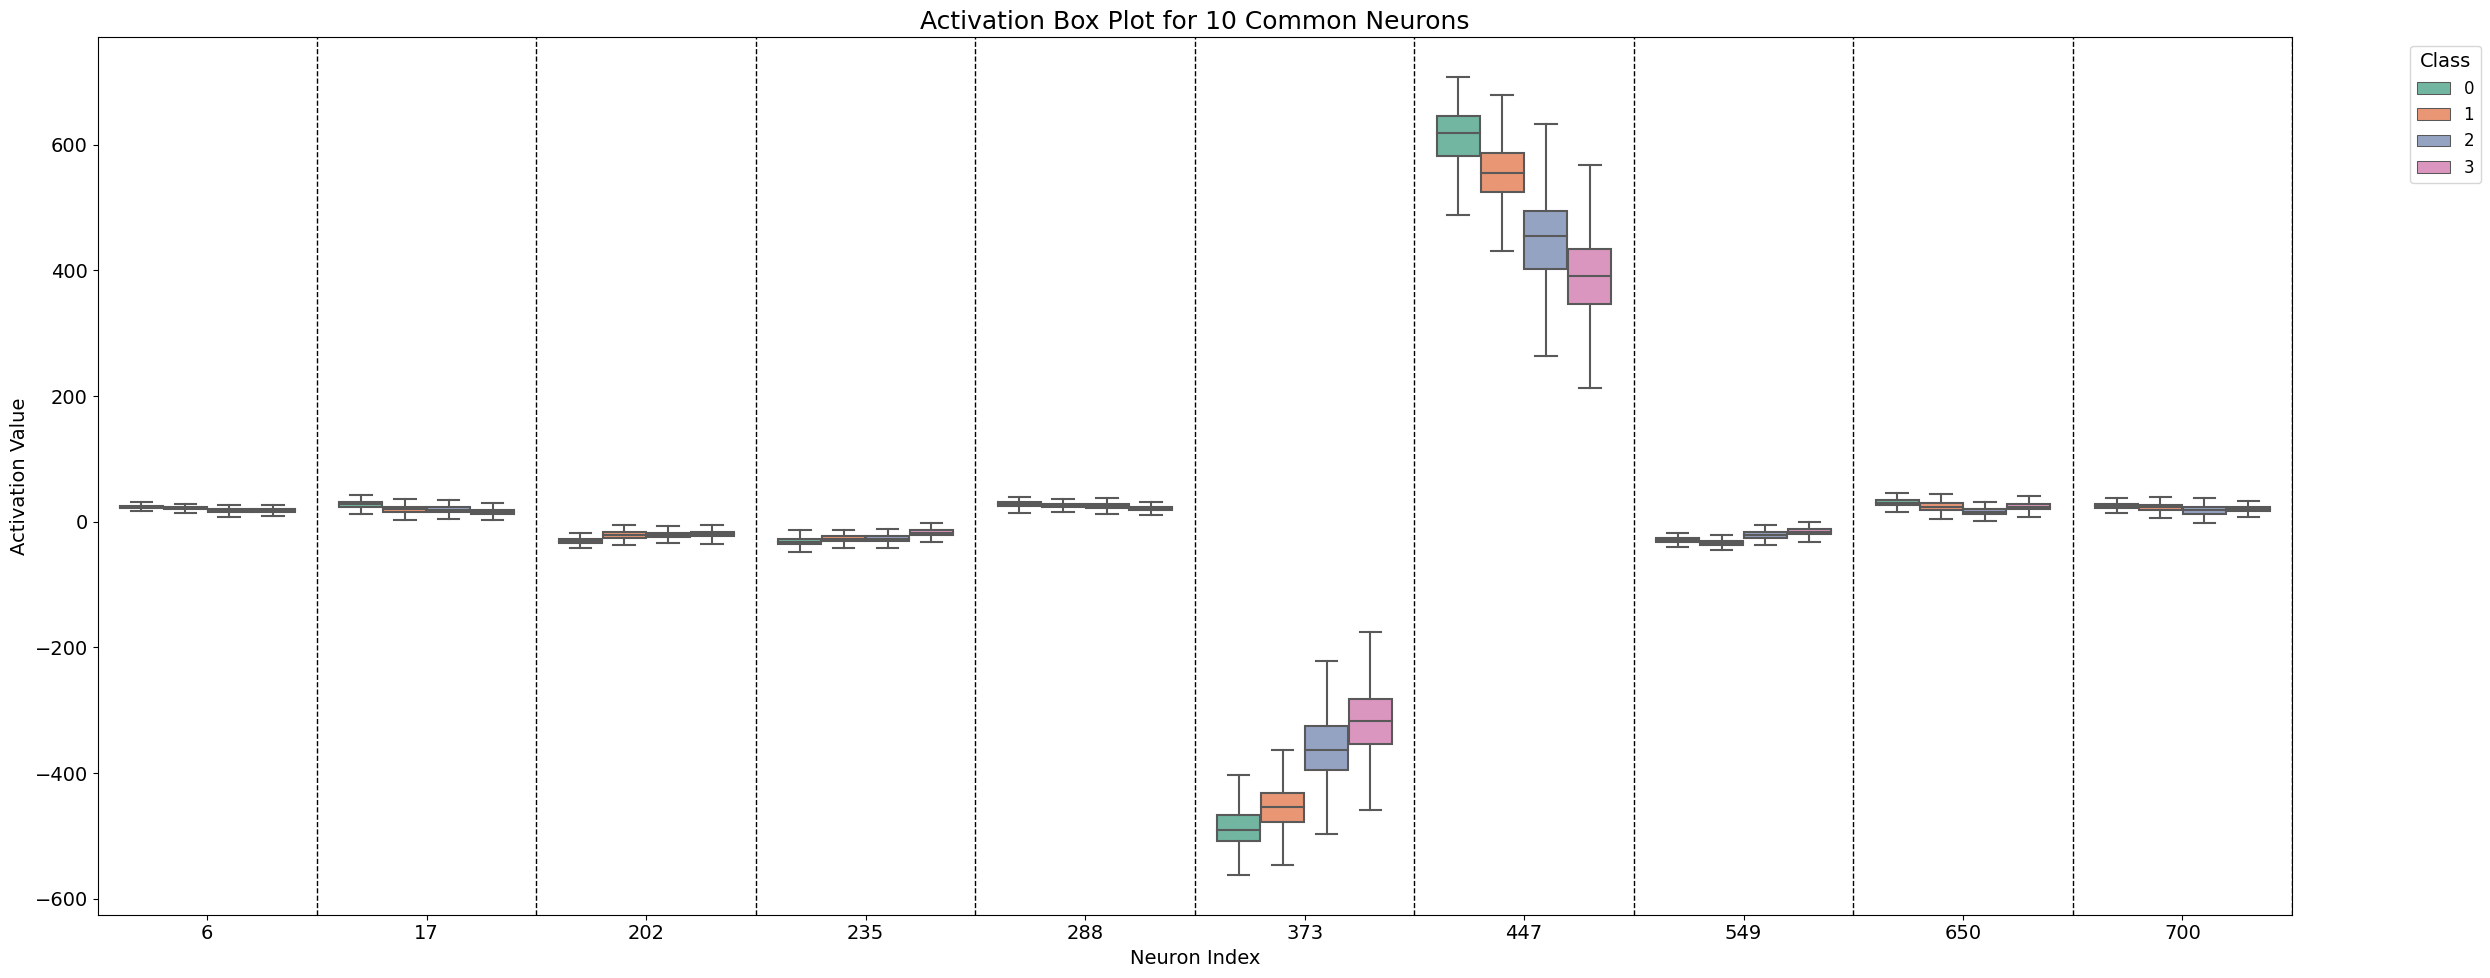

Plotted neuron indices: [17, 373, 235, 447, 288, 6, 700, 202, 549, 650]


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
 
 
def find_common_neurons(all_masked_indices):
    """
    Find neuron indices common across all classes
    """
    # Use set intersection to find common indices
    common_neurons = set(all_masked_indices[0])
    for indices in all_masked_indices[1:]:
        common_neurons = common_neurons.intersection(indices)
    
    return list(common_neurons)
 
def prepare_neuron_data(all_fc_vals, neurons_to_plot,classes_chosen):
    """
    Prepare activation data for common neurons across all classes
    """
    plot_data = []
    
    # Extract masks for each class
    masks = [compute_masks(activations, 0.50)[0] for activations in [all_fc_vals[i] for i in classes_chosen]]
    
    for class_label, (activations, mask) in enumerate(zip([all_fc_vals[i] for i in classes_chosen], masks)):
        # Get neuron indices for this class based on mask where mask is zero (indicating selected neurons)
        class_neuron_indices = np.where(mask == 0)[0]  # These are the neuron indices where the mask is 0
        activations = np.array(activations)  # Ensure activations is a NumPy array
        
        print(neurons_to_plot)
        
        # Filter to only common neurons
        common_neuron_mask = np.isin(class_neuron_indices, neurons_to_plot)  # Find neurons in common_neuron_mask
        common_neuron_mask = np.where(common_neuron_mask, 0, 1).astype(int)  # Convert True/False to 0/1
        
        # Get the indices where mask is 0 for common neurons
        common_neuron_indices = class_neuron_indices[common_neuron_mask == 0]  # Only take indices where mask is 0
        
        # Extract activations for common neurons
        filtered_activations = activations[:, common_neuron_indices]  # Use these indices to filter activations
        
        #for each neuron normalize the filtered activations
        
        # Create DataFrame with both neuron index and class label
        df = pd.DataFrame(filtered_activations)
        df = df.melt(var_name='Neuron_Local', value_name='Activation')
        
        # Map local neuron indices back to original neuron numbers
        df['Neuron'] = df['Neuron_Local'].apply(lambda x: common_neuron_indices[x])
        df['Class'] = class_label
        
        plot_data.append(df)
 
   
    
    # Combine data for all classes
    return pd.concat(plot_data, ignore_index=True)
 
def plot_overlapping_neurons(all_fc_vals, max_neurons_to_plot,classes_chosen):
    # Extract max masks for each class
    all_masked_indices = []
    
    for class_label, activations in enumerate([all_fc_vals[i] for i in classes_chosen]):
        # Compute masks for the current class's activations
        mask_max, _, _, _, _, _, _, _ = compute_masks(activations, 0.15)
        
        # Use max mask and get its neuron indices
        class_neuron_indices = np.where(mask_max == 0)[0]
        class_neuron_indices =[int(neuron) for neuron in class_neuron_indices]
        all_masked_indices.append(class_neuron_indices)
    
    # Find common neuron indices across classes
    common_neurons = find_common_neurons(all_masked_indices)
    common_neurons=[int(neuron) for neuron in common_neurons]
    print("Commo|n nuerons",common_neurons)
    # n_neurons_to_plot = np.random.randint(1, min(len(common_neurons), max_neurons_to_plot) + 1)
    
    # Randomly select neurons to plot
    neurons_to_plot = np.random.choice(common_neurons, size=min(len(common_neurons), max_neurons_to_plot), replace=False)
    # Select top n common neurons to plot
    # neurons_to_plot = common_neurons[:n_neurons_to_plot]
    neurons_to_plot = [int(neuron) for neuron in neurons_to_plot]
    print(neurons_to_plot)
    
    # Prepare data for plotting
    plot_df = prepare_neuron_data(all_fc_vals, neurons_to_plot,classes_chosen)
    
    # Create plot
    plt.figure(figsize=(25, 10))
    palette = sns.color_palette("Set2", n_colors=len(plot_df['Class'].unique()))
    
    sns.boxplot(data=plot_df, x='Neuron', y='Activation', hue='Class',
                showfliers=False, palette=palette)
    # neuron_indices = [0, 4, 6, 12]  # Example indices where dashed lines should appear
    for pos in range(len(neurons_to_plot)):  # Use `neurons_to_plot` here
        plt.axvline(x=pos+0.5, color='black', linestyle='--', linewidth=1)
        
    plt.title(f'Activation Box Plot for {len(neurons_to_plot)} Common Neurons', fontsize=18)
    plt.xlabel('Neuron Index', fontsize=14)
    plt.ylabel('Activation Value', fontsize=14)
    plt.legend(title='Class', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return neurons_to_plot
np.random.seed(21)#21
classes_chosen=np.random.choice([0,1,2,3], size=4, replace=False)
print(classes_chosen)
# Call the function with your activations
plot_neurons = plot_overlapping_neurons(all_fc_vals, max_neurons_to_plot=10,classes_chosen=classes_chosen)
print(f"Plotted neuron indices:", plot_neurons)

[3 2 0 1]


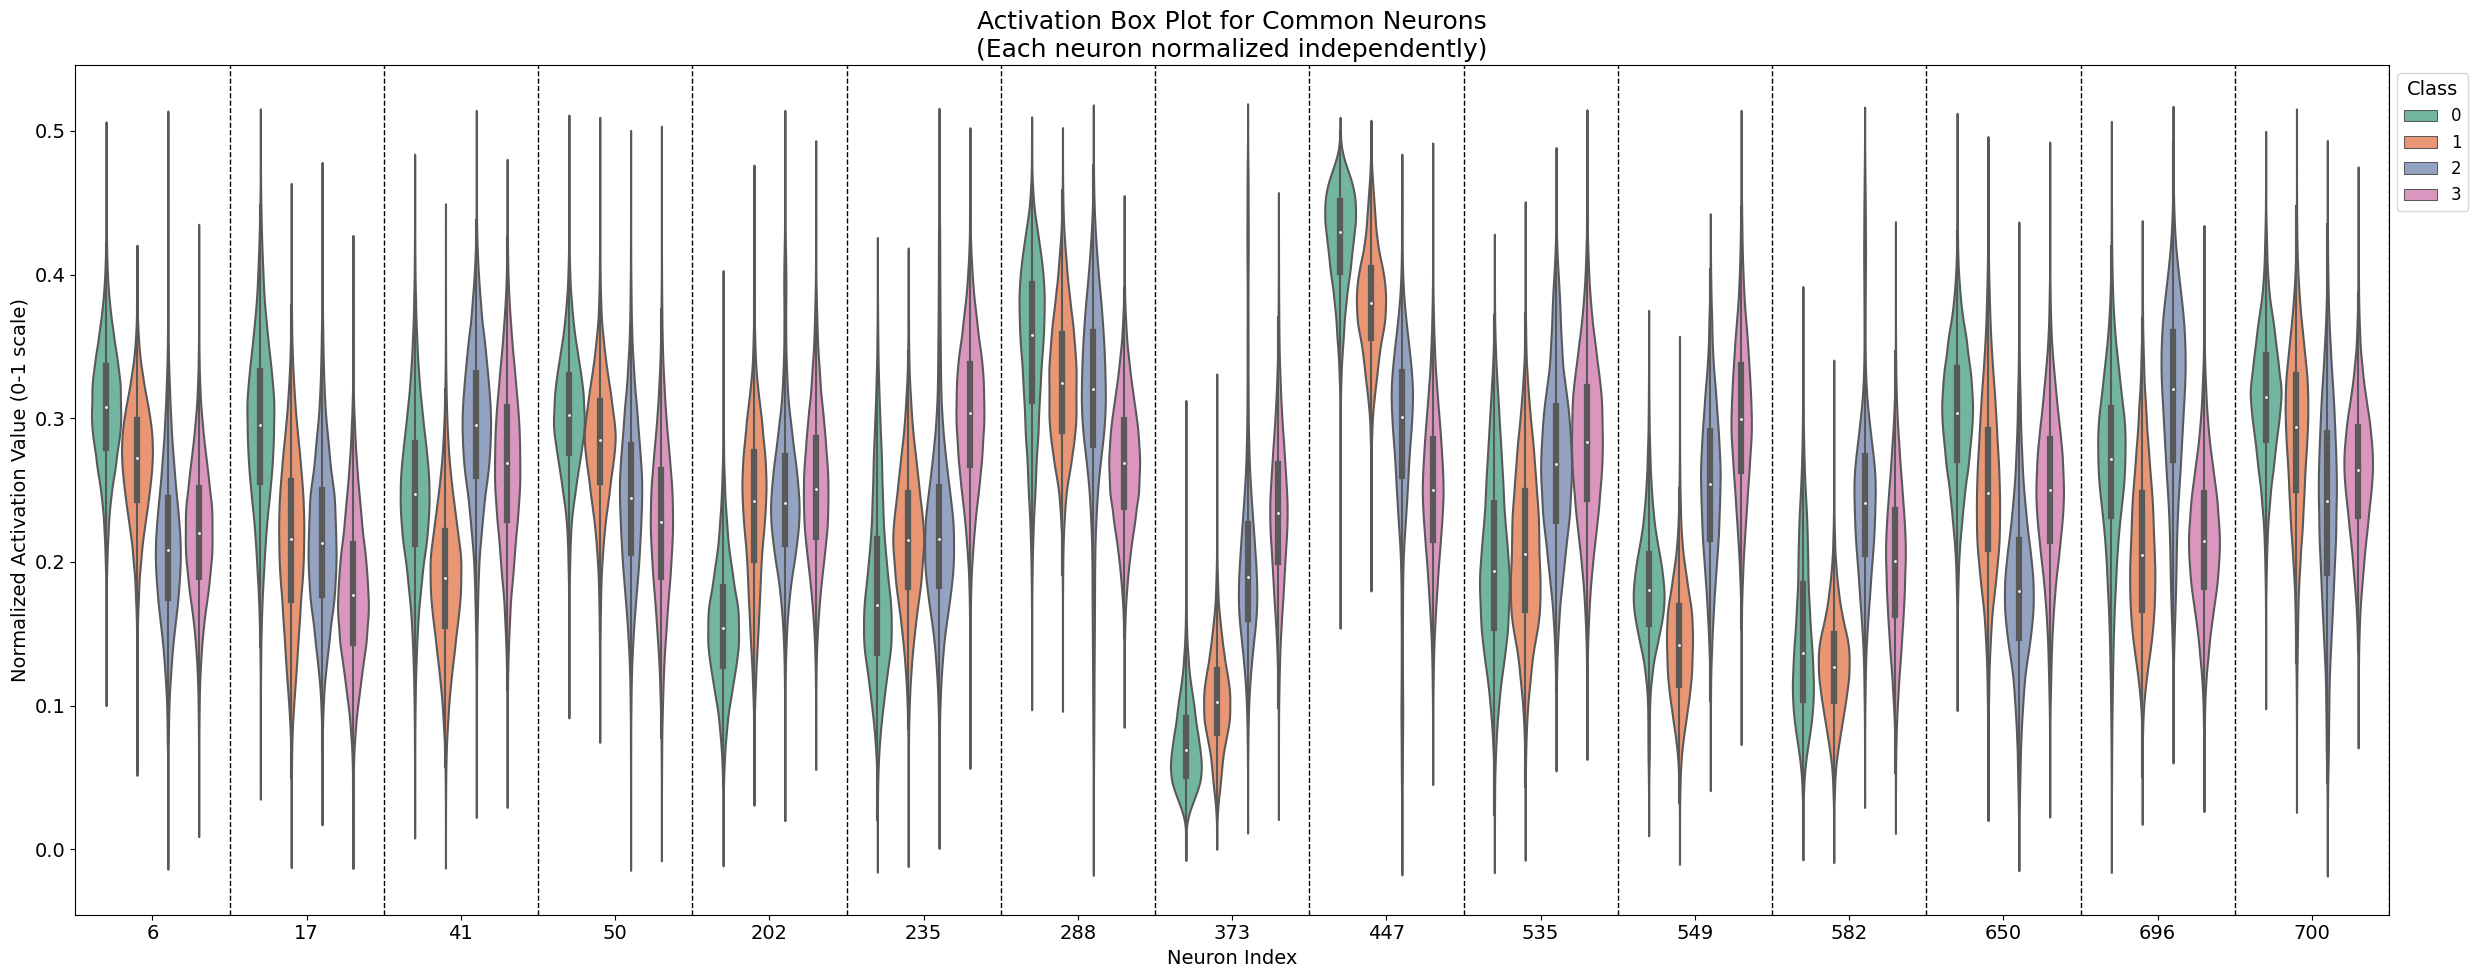

Plotted neuron indices: [17, 373, 235, 447, 288, 6, 700, 202, 549, 650, 582, 50, 41, 535, 696]


In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def find_common_neurons(all_masked_indices):
    """
    Find neuron indices common across all classes
    """
    # Use set intersection to find common indices
    common_neurons = set(all_masked_indices[0])
    for indices in all_masked_indices[1:]:
        common_neurons = common_neurons.intersection(indices)
    
    return list(common_neurons)
def prepare_neuron_data(all_fc_vals, neurons_to_plot, classes_chosen):
    """
    Prepare activation data for common neurons across all classes with per-neuron normalization
    """
    plot_data = []
    
    # Extract masks for each class
    masks = [compute_masks(activations, 0.05)[0] for activations in [all_fc_vals[i] for i in classes_chosen]]
    
    # First, collect all activations for each neuron across all classes
    all_neuron_activations = {}
    for neuron in neurons_to_plot:
        all_neuron_activations[neuron] = []
    
    # Gather all activations for each neuron
    for class_label, activations in enumerate([all_fc_vals[i] for i in classes_chosen]):
        activations = np.array(activations)
        for neuron in neurons_to_plot:
            all_neuron_activations[neuron].extend(activations[:, neuron].tolist())
    
    # Calculate normalization parameters for each neuron
    neuron_stats = {}
    for neuron in neurons_to_plot:
        values = np.array(all_neuron_activations[neuron])
        neuron_stats[neuron] = {
            'min': np.min(values),
            'max': np.max(values)
        }
    
    # Now process each class with normalized values
    for class_label, (activations, mask) in enumerate(zip([all_fc_vals[i] for i in classes_chosen], masks)):
        activations = np.array(activations)
        
        # Create DataFrame for this class
        neuron_data = []
        for neuron_idx, neuron in enumerate(neurons_to_plot):
            # Extract activations for this neuron
            neuron_activations = activations[:, neuron]
            
            # Normalize using min-max scaling
            min_val = neuron_stats[neuron]['min']
            max_val = neuron_stats[neuron]['max']
            
            # Avoid division by zero
            if max_val - min_val != 0:
                normalized_activations = (neuron_activations - min_val) / (max_val - min_val)/2
            else:
                normalized_activations = neuron_activations - min_val
            
            # Create entries for this neuron
            for activation in normalized_activations:
                neuron_data.append({
                    'Neuron_Local': neuron_idx,
                    'Neuron': neuron,
                    'Activation': activation,
                    'Class': class_label
                })
        
        plot_data.append(pd.DataFrame(neuron_data))
    
    # Combine data for all classes
    return pd.concat(plot_data, ignore_index=True)

def plot_overlapping_neurons(all_fc_vals, max_neurons_to_plot, classes_chosen):
    # Extract max masks for each class
    all_masked_indices = []
    
    for class_label, activations in enumerate([all_fc_vals[i] for i in classes_chosen]):
        mask_max, _, _, _, _, _, _, _ = compute_masks(activations, 0.15)
        class_neuron_indices = np.where(mask_max == 0)[0]
        class_neuron_indices = [int(neuron) for neuron in class_neuron_indices]
        all_masked_indices.append(class_neuron_indices)
    
    common_neurons = find_common_neurons(all_masked_indices)
    common_neurons = [int(neuron) for neuron in common_neurons]
    
    neurons_to_plot = np.random.choice(common_neurons, size=min(len(common_neurons), max_neurons_to_plot), replace=False)
    neurons_to_plot = [int(neuron) for neuron in neurons_to_plot]
    
    # Prepare data for plotting
    plot_df = prepare_neuron_data(all_fc_vals, neurons_to_plot, classes_chosen)
    
    # Create plot
    plt.figure(figsize=(25, 10))
    # plt.cm.rainbow(np.linspace(0, 1, len(dataset_names)))
    palette = sns.color_palette("Set2", n_colors=len(plot_df['Class'].unique()))
    
    # Create the boxplot with normalized values
    sns.violinplot(data=plot_df, x='Neuron', y='Activation', hue='Class',
                showfliers=False, palette=palette)
    
    for pos in range(len(neurons_to_plot)):
        plt.axvline(x=pos+0.5, color='black', linestyle='--', linewidth=1)
    
    plt.title('Activation Box Plot for Common Neurons\n(Each neuron normalized independently)', fontsize=18)
    plt.xlabel('Neuron Index', fontsize=14)
    plt.ylabel('Normalized Activation Value (0-1 scale)', fontsize=14)
    plt.legend(title='Class', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('common_neurons_box_plot.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.show()
    
    return neurons_to_plot
np.random.seed(21)#21
classes_chosen=np.random.choice([0,1,2,3], size=4, replace=False)
print(classes_chosen)
# Call the function with your activations
plot_neurons = plot_overlapping_neurons(dataset_fc[0], max_neurons_to_plot=15,classes_chosen=classes_chosen)
print(f"Plotted neuron indices:", plot_neurons)

In [57]:
import torch
import numpy as np
from scipy.stats import gaussian_kde
import torch.nn.functional as F
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

class RangeAnalysis:
    def __init__(self, class_activations):
        self.class_activations = class_activations
        # self.n_neurons = class_activations[0][0].shape[1]
        
    def compute_neuron_ranges(self, neuron_idx, tau=2.5):
        """Compute activation ranges for each class for a given neuron"""
        ranges = {}
        for class_idx, activations in self.class_activations.items():
            neuron_acts = activations[:, neuron_idx]
            mean = neuron_acts.mean()
            std = neuron_acts.std()
            ranges[class_idx] = {
                'lower': mean - tau * std,
                'upper': mean + tau * std,
                'distribution': neuron_acts
            }
        return ranges
    
    def analyze_range_overlap(self, neuron_idx):
        """Analyze how much ranges overlap between classes"""
        ranges = self.compute_neuron_ranges(neuron_idx)
        overlaps = {}
        
        for c1 in ranges:
            for c2 in ranges:
                if c1 >= c2:
                    continue
                    
                # Compute KL divergence between distributions
                acts1 = ranges[c1]['distribution']
                acts2 = ranges[c2]['distribution']
                
                kde1 = gaussian_kde(acts1)
                kde2 = gaussian_kde(acts2)
                
                # Sample points and compute KL divergence
                x = np.linspace(min(acts1.min(), acts2.min()), 
                              max(acts1.max(), acts2.max()), 1000)
                p = kde1(x)
                q = kde2(x)
                kl_div = (p * np.log(p/q)).sum()
                
                overlaps[(c1, c2)] = kl_div
        
        return overlaps
    
    
class InformationAnalysis:
    def __init__(self, class_activations):
        self.class_activations = class_activations
    
    def compute_mutual_information(self, neuron_idx, n_bins=50):
        """Compute mutual information between neuron and class labels"""
        all_acts = []
        all_labels = []
        
        for class_idx, acts in self.class_activations.items():
            neuron_acts = acts[:, neuron_idx]
            all_acts.extend(neuron_acts.numpy())
            all_labels.extend([class_idx] * len(neuron_acts))
            
        # Discretize activations
        act_bins = np.histogram_bin_edges(all_acts, bins=n_bins)
        discretized_acts = np.digitize(all_acts, act_bins)
        
        return mutual_info_score(discretized_acts, all_labels)
    
    def analyze_range_information(self, neuron_idx, ranges):
        """Analyze mutual information in different activation ranges"""
        range_mi = {}
        
        for class_idx, range_info in ranges.items():
            # Get activations in range
            mask = ((self.class_activations[class_idx][:, neuron_idx] >= range_info['lower']) & 
                (self.class_activations[class_idx][:, neuron_idx] <= range_info['upper']))
            
            if mask.any():
                range_acts = self.class_activations[class_idx][mask][:, neuron_idx]
                range_mi[class_idx] = self.compute_mutual_information_range(range_acts, class_idx)
                
        return range_mi
def run_range_analysis(class_acts, threshold=0.5):
    range_analyzer = RangeAnalysis(class_acts)
    
    # Find neurons with distinct ranges per class
    salient_neurons = []
    for n in range(range_analyzer.n_neurons):
        overlaps = range_analyzer.analyze_range_overlap(n)
        if max(overlaps.values()) < threshold:
            salient_neurons.append(n)
    
    return salient_neurons

# 2. Information Theory Analysis
def run_information_analysis():
    info_analyzer = InformationAnalysis(class_acts)
    
    # Analyze MI across different range widths
    mi_scores = []
    range_widths = np.linspace(1.0, 4.0, 10)
    
    for width in range_widths:
        ranges = range_analyzer.compute_neuron_ranges(neuron_idx, tau=width)
        mi = info_analyzer.analyze_range_information(neuron_idx, ranges)
        mi_scores.append(mi)
        
    return mi_scores

In [3]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

class RangeAnalysis:
    def __init__(self, class_activations: List[np.ndarray]):
        """
        Parameters:
        - class_activations: List of numpy arrays, where each array has shape (n_samples, hidden_size)
                           Index in list represents the class
        """
        self.class_activations = class_activations
        self.n_classes = len(class_activations)
        self.n_neurons = class_activations[0].shape[1]
        self.class_sizes = [acts.shape[0] for acts in class_activations]
        
        print(f"Number of classes: {self.n_classes}")
        print(f"Number of neurons: {self.n_neurons}")
        print("Samples per class:", self.class_sizes)
        
    def compute_neuron_ranges(self, neuron_idx: int, tau: float = 2.5) -> Dict:
        """Compute activation ranges for each class for a given neuron"""
        ranges = {}
        
        for class_idx in range(self.n_classes):
            neuron_acts = self.class_activations[class_idx][:, neuron_idx]
            mean = np.mean(neuron_acts)
            std = np.std(neuron_acts)
            
            ranges[class_idx] = {
                'lower': mean - tau * std,
                'upper': mean + tau * std,
                'mean': mean,
                'std': std,
                'distribution': neuron_acts
            }
            
        return ranges
    
    def analyze_range_overlap(self, neuron_idx: int) -> float:
        """
        Analyze how much ranges overlap between classes using KL divergence
        Returns max overlap score (lower is better)
        """
        ranges = self.compute_neuron_ranges(neuron_idx)
        overlaps = {}
        
        for c1 in range(self.n_classes):
            for c2 in range(c1 + 1, self.n_classes):
                acts1 = ranges[c1]['distribution']
                acts2 = ranges[c2]['distribution']
                
                # Compute KL divergence using KDE
                try:
                    kde1 = gaussian_kde(acts1)
                    kde2 = gaussian_kde(acts2)
                    
                    # Sample points for KL computation
                    x = np.linspace(min(acts1.min(), acts2.min()),
                                  max(acts1.max(), acts2.max()),
                                  1000)
                    p = kde1(x)
                    q = kde2(x)
                    
                    # Avoid division by zero
                    eps = 1e-10
                    kl_div = np.sum(p * np.log(p / (q + eps) + eps))
                    
                    overlaps[(c1, c2)] = kl_div
                except:
                    # If KDE fails (e.g., constant values), assign high overlap
                    overlaps[(c1, c2)] = float('inf')
        
        return min(overlaps.values()) if overlaps else float('inf')
    
    def visualize_neuron(self, neuron_idx: int, save_path: str = None):
        """Visualize activation distributions for a neuron across all classes"""
        ranges = self.compute_neuron_ranges(neuron_idx)
        
        plt.figure(figsize=(12, 6))
        colors = plt.cm.rainbow(np.linspace(0, 1, self.n_classes))
        
        for class_idx, color in zip(range(self.n_classes), colors):
            range_info = ranges[class_idx]
            
            # Plot distribution
            sns.kdeplot(range_info['distribution'], 
                       label=f'Class {class_idx} (n={len(range_info["distribution"])})',
                       color=color)
            
            # Plot range boundaries
            plt.axvline(range_info['lower'], color=color, linestyle='--', alpha=0.5)
            plt.axvline(range_info['upper'], color=color, linestyle='--', alpha=0.5)
        
        plt.title(f'Activation Distributions for Neuron {neuron_idx}')
        plt.xlabel('Activation Value')
        plt.ylabel('Density')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path)
        plt.close()

def run_range_analysis(class_activations: List[np.ndarray], 
                      threshold: float = 0.5,
                      visualize_top_k: int = 5) -> List[int]:
    """
    Find neurons with distinct ranges per class
    
    Parameters:
    - class_activations: List of numpy arrays with shape (n_samples, hidden_size)
    - threshold: Maximum allowed overlap between classes
    - visualize_top_k: Number of top neurons to visualize
    
    Returns:
    - List of neuron indices with distinct ranges
    """
    analyzer = RangeAnalysis(class_activations)
    
    # Track overlap scores for all neurons
    neuron_scores = {}
    
    for n in range(analyzer.n_neurons):
        overlap = analyzer.analyze_range_overlap(n)
        neuron_scores[n] = overlap
    
    # Sort neurons by overlap score (lower is better)
    sorted_neurons = sorted(neuron_scores.items(), key=lambda x: x[1])
    
    # Get neurons below threshold
    salient_neurons = [n for n, score in sorted_neurons if score < threshold]
    
    print(f"\nFound {len(salient_neurons)} neurons below threshold {threshold}")
    
    # Visualize top K neurons
    for n, score in sorted_neurons[:visualize_top_k]:
        print(f"\nNeuron {n} - Overlap Score: {score:.4f}")
        analyzer.visualize_neuron(n, f'neuron_{n}_ranges.png')
    
    return salient_neurons
import warnings
from pandas.errors import SettingWithCopyWarning

def visualize_neuron(self, neuron_idx: int, save_path: str = None):
    """Visualize activation distributions for a neuron across all classes"""
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
        
        ranges = self.compute_neuron_ranges(neuron_idx)
        plt.figure(figsize=(12, 6))
        
        for class_idx in range(self.n_classes):
            range_info = ranges[class_idx]
            
            # Get clean distribution stats
            mean = range_info['mean']
            std = range_info['std']
            
            # Plot distribution with stats
            sns.kdeplot(range_info['distribution'], 
                       label=f'Class {class_idx} (μ={mean:.2f}, σ={std:.2f})')
            
            # Add range markers
            plt.axvline(range_info['lower'], color='gray', 
                       linestyle='--', alpha=0.3)
            plt.axvline(range_info['upper'], color='gray', 
                       linestyle='--', alpha=0.3)
        
        plt.title(f'Neuron {neuron_idx} (Overlap Score: {self.analyze_range_overlap(neuron_idx):.4f})')
        plt.xlabel('Activation Value')
        plt.ylabel('Density')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
        
def analyze_salient_neurons(class_activations, salient_neurons):
    """Detailed analysis of salient neurons"""
    analyzer = RangeAnalysis(class_activations)
    
    neuron_stats = {}
    for n in salient_neurons:
        ranges = analyzer.compute_neuron_ranges(n)
        
        # Compute class separability metrics
        separability = {}
        for c1 in range(analyzer.n_classes):
            for c2 in range(c1 + 1, analyzer.n_classes):
                dist1 = ranges[c1]['distribution']
                dist2 = ranges[c2]['distribution']
                
                # Calculate effect size (Cohen's d)
                pooled_std = np.sqrt((np.var(dist1) + np.var(dist2)) / 2)
                cohens_d = abs(np.mean(dist1) - np.mean(dist2)) / pooled_std
                
                separability[f'class_{c1}_vs_{c2}'] = {
                    'cohens_d': cohens_d,
                    'overlap_coefficient': analyzer.compute_overlap_coefficient(dist1, dist2)
                }
        
        neuron_stats[n] = {
            'ranges': ranges,
            'separability': separability,
            'overall_score': analyzer.analyze_range_overlap(n)
        }
    
    return neuron_stats

# Print summary of findings
def print_analysis_summary(neuron_stats):
    print(f"\nDetailed Analysis of {len(neuron_stats)} Salient Neurons:\n")
    
    for neuron, stats in sorted(neuron_stats.items(), 
                              key=lambda x: x[1]['overall_score']):
        print(f"Neuron {neuron}:")
        print(f"Overall overlap score: {stats['overall_score']:.4f}")
        
        # Print class separation stats
        print("Class separability:")
        for pair, metrics in stats['separability'].items():
            print(f"  {pair}:")
            print(f"    Cohen's d: {metrics['cohens_d']:.4f}")
            print(f"    Overlap coefficient: {metrics['overlap_coefficient']:.4f}")
        print()
        
        
def analyze_overlap_distribution(salient_neurons, neuron_scores):
    """Analyze the distribution of overlap scores"""
    scores = [neuron_scores[n] for n in salient_neurons]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(scores, bins=20)
    plt.axvline(np.median(scores), color='r', linestyle='--', 
                label=f'Median: {np.median(scores):.4f}')
    plt.title('Distribution of Overlap Scores for Salient Neurons')
    plt.xlabel('Overlap Score')
    plt.ylabel('Count')
    plt.legend()
    plt.savefig('overlap_distribution.png')
    plt.close()

# Example usage:


In [ ]:
fc = dataset_fc[0]
fc_array = []
for cls in fc:
    fc_array.append(np.array(cls))

salient_neurons = run_range_analysis(fc_array, threshold=0.5)

In [8]:
# First run your existing code to get salient neurons
fc = dataset_fc[0]
fc_array = []
for cls in fc:
    fc_array.append(np.array(cls))

# salient_neurons = run_range_analysis(fc_array, threshold=0.5)

# Now let's do detailed analysis
# 1. Get detailed stats for salient neurons
neuron_stats = analyze_salient_neurons(fc_array, salient_neurons)

# 2. Print summary
print_analysis_summary(neuron_stats)

# 3. Analyze distribution
analyzer = RangeAnalysis(fc_array)
all_neuron_scores = {n: analyzer.analyze_range_overlap(n) 
                    for n in range(analyzer.n_neurons)}
analyze_overlap_distribution(salient_neurons, all_neuron_scores)

# 4. Optional: Create detailed visualization of top N neurons
N = 10  # Adjust as needed
top_neurons = sorted(neuron_stats.items(), 
                    key=lambda x: x[1]['overall_score'])[:N]

for neuron, stats in top_neurons:
    plt.figure(figsize=(15, 5))
    
    # Left subplot: distributions
    plt.subplot(1, 2, 1)
    ranges = stats['ranges']
    for class_idx in range(len(fc_array)):
        sns.kdeplot(ranges[class_idx]['distribution'], 
                   label=f'Class {class_idx}')
    plt.title(f'Neuron {neuron} Distributions')
    plt.legend()
    
    # Right subplot: pairwise separations
    plt.subplot(1, 2, 2)
    sep_scores = [[0]*len(fc_array) for _ in range(len(fc_array))]
    for pair, metrics in stats['separability'].items():
        c1, c2 = map(int, pair.split('_')[1::2])
        sep_scores[c1][c2] = metrics['cohens_d']
        sep_scores[c2][c1] = metrics['cohens_d']
    
    sns.heatmap(sep_scores, annot=True, cmap='YlOrRd')
    plt.title('Pairwise Class Separation (Cohen\'s d)')
    
    plt.tight_layout()
    plt.savefig(f'neuron_{neuron}_detailed.png')
    plt.close()

# 5. Optional: Save statistics to file
import json
with open('salient_neuron_stats.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    serializable_stats = {}
    for n, stats in neuron_stats.items():
        serializable_stats[str(n)] = {
            'overall_score': float(stats['overall_score']),
            'separability': {
                k: {
                    'cohens_d': float(v['cohens_d']),
                    'overlap_coefficient': float(v['overlap_coefficient'])
                }
                for k, v in stats['separability'].items()
            }
        }
    json.dump(serializable_stats, f, indent=2)

print("\nAnalysis complete! Check the generated visualizations and salient_neuron_stats.json")

Number of classes: 4
Number of neurons: 768
Samples per class: [2000, 2000, 2000, 2000]


AttributeError: 'RangeAnalysis' object has no attribute 'compute_overlap_coefficient'

In [5]:
#Inharit the class RangeAnalysis and add the following methods
import numpy as np
import pandas as pd



class RangeAnalysis:
    def __init__(self, class_activations: List[np.ndarray]):
        self.class_activations = class_activations
        self.n_classes = len(class_activations)
        self.n_neurons = class_activations[0].shape[1]
        self.class_sizes = [acts.shape[0] for acts in class_activations]
        
        print(f"Number of classes: {self.n_classes}")
        print(f"Number of neurons: {self.n_neurons}")
        print("Samples per class:", self.class_sizes)
    
    def compute_overlap_coefficient(self, dist1: np.ndarray, dist2: np.ndarray) -> float:
        """
        Compute overlap coefficient between two distributions
        Using histogram intersection method
        """
        hist1, bins = np.histogram(dist1, bins=50, density=True)
        hist2, _ = np.histogram(dist2, bins=bins, density=True)
        
        # Normalize histograms
        hist1 = hist1 / hist1.sum()
        hist2 = hist2 / hist2.sum()
        
        # Compute overlap
        overlap = np.minimum(hist1, hist2).sum()
        return overlap
    
    def visualize_neuron(self, neuron_idx: int, save_path: str = None):
        """Visualize activation distributions for a neuron across all classes"""
        ranges = self.compute_neuron_ranges(neuron_idx)
        
        plt.figure(figsize=(12, 6))
        colors = plt.cm.rainbow(np.linspace(0, 1, self.n_classes))
        
        for class_idx, color in zip(range(self.n_classes), colors):
            range_info = ranges[class_idx]
            
            # Plot distribution
            sns.kdeplot(range_info['distribution'], 
                       label=f'Class {class_idx} (n={len(range_info["distribution"])})',
                       color=color)
            
            # Plot range boundaries
            plt.axvline(range_info['lower'], color=color, linestyle='--', alpha=0.5)
            plt.axvline(range_info['upper'], color=color, linestyle='--', alpha=0.5)
        
        plt.title(f'Activation Distributions for Neuron {neuron_idx}')
        plt.xlabel('Activation Value')
        plt.ylabel('Density')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path)
        plt.close()
    
    def compute_neuron_ranges(self, neuron_idx: int, tau: float = 2.5) -> Dict:
        ranges = {}
        for class_idx in range(self.n_classes):
            neuron_acts = self.class_activations[class_idx][:, neuron_idx]
            mean = np.mean(neuron_acts)
            std = np.std(neuron_acts)
            
            ranges[class_idx] = {
                'lower': mean - tau * std,
                'upper': mean + tau * std,
                'mean': mean,
                'std': std,
                'distribution': neuron_acts
            }
        return ranges
    
    def analyze_range_overlap(self, neuron_idx: int) -> float:
        ranges = self.compute_neuron_ranges(neuron_idx)
        overlaps = {}
        
        for c1 in range(self.n_classes):
            for c2 in range(c1 + 1, self.n_classes):
                acts1 = ranges[c1]['distribution']
                acts2 = ranges[c2]['distribution']
                
                try:
                    kde1 = gaussian_kde(acts1)
                    kde2 = gaussian_kde(acts2)
                    
                    x = np.linspace(min(acts1.min(), acts2.min()),
                                  max(acts1.max(), acts2.max()),
                                  1000)
                    p = kde1(x)
                    q = kde2(x)
                    
                    eps = 1e-10
                    kl_div = np.sum(p * np.log(p / (q + eps) + eps))
                    overlaps[(c1, c2)] = kl_div
                except:
                    overlaps[(c1, c2)] = float('inf')
        
        return min(overlaps.values()) if overlaps else float('inf')

def analyze_salient_neurons(class_activations, salient_neurons):
    """Detailed analysis of salient neurons"""
    analyzer = RangeAnalysis(class_activations)
    
    neuron_stats = {}
    for n in salient_neurons:
        ranges = analyzer.compute_neuron_ranges(n)
        
        # Compute class separability metrics
        separability = {}
        for c1 in range(analyzer.n_classes):
            for c2 in range(c1 + 1, analyzer.n_classes):
                dist1 = ranges[c1]['distribution']
                dist2 = ranges[c2]['distribution']
                
                # Calculate effect size (Cohen's d)
                pooled_std = np.sqrt((np.var(dist1) + np.var(dist2)) / 2)
                cohens_d = abs(np.mean(dist1) - np.mean(dist2)) / pooled_std
                
                separability[f'class_{c1}_vs_{c2}'] = {
                    'cohens_d': cohens_d,
                    'overlap_coefficient': analyzer.compute_overlap_coefficient(dist1, dist2)
                }
        
        neuron_stats[n] = {
            'ranges': ranges,
            'separability': separability,
            'overall_score': analyzer.analyze_range_overlap(n)
        }
    
    return neuron_stats

# Usage example
fc = dataset_fc[0]
fc_array = []
for cls in fc:
    fc_array.append(np.array(cls))

# Get salient neurons
salient_neurons = run_range_analysis(fc_array, threshold=0.5)

# Get detailed stats
neuron_stats = analyze_salient_neurons(fc_array, salient_neurons)

# Print summary
print_analysis_summary(neuron_stats)

# Analyze distribution
analyzer = RangeAnalysis(fc_array)
all_neuron_scores = {n: analyzer.analyze_range_overlap(n) 
                    for n in range(analyzer.n_neurons)}
analyze_overlap_distribution(salient_neurons, all_neuron_scores)

Number of classes: 4
Number of neurons: 768
Samples per class: [2000, 2000, 2000, 2000]

Found 89 neurons below threshold 0.5

Neuron 172 - Overlap Score: 0.0628


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in


Neuron 459 - Overlap Score: 0.0753


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in


Neuron 512 - Overlap Score: 0.0908


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in


Neuron 334 - Overlap Score: 0.0950


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in


Neuron 250 - Overlap Score: 0.1068


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

Number of classes: 4
Number of neurons: 768
Samples per class: [2000, 2000, 2000, 2000]

Detailed Analysis of 89 Salient Neurons:

Neuron 172:
Overall overlap score: 0.0628
Class separability:
  class_0_vs_1:
    Cohen's d: 1.1100
    Overlap coefficient: 0.5769
  class_0_vs_2:
    Cohen's d: 0.7526
    Overlap coefficient: 0.7116
  class_0_vs_3:
    Cohen's d: 1.0766
    Overlap coefficient: 0.5902
  class_1_vs_2:
    Cohen's d: 0.2059
    Overlap coefficient: 0.8153
  class_1_vs_3:
    Cohen's d: 0.0319
    Overlap coefficient: 0.9395
  class_2_vs_3:
    Cohen's d: 0.1782
    Overlap coefficient: 0.8277

Neuron 459:
Overall overlap score: 0.0753
Class separability:
  class_0_vs_1:
    Cohen's d: 0.9263
    Overlap coefficient: 0.5780
  class_0_vs_2:
    Cohen's d: 0.2224
    Overlap coefficient: 0.9131
  class_0_vs_3:
    Cohen's d: 0.2051
    Overlap coefficient: 0.9002
  class_1_vs_2:
    Cohen's d: 1.2419
    Overlap coefficient: 0.5503
  class_1_vs_3:
    Cohen's d: 1.2167
    Ov

/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [6]:
# empty gpu memory

import torch
torch.cuda.empty_cache()
